In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,"../python/rrvf2017/")

In [3]:
from rrvf_data import read_data,show_data,show_data2,show_features, normalize, DataGen

In [4]:
columns,data=read_data()
len(columns),data.shape

(1, 829, 517) (54, 829, 517)


(62, (829, 517, 62))

In [5]:
gc.collect()

15

In [6]:
#show_data(data,columns, 1,480, None)

In [7]:
#show_data2(data,columns)

# cv

In [8]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [9]:
def get_index(cols):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [10]:
rawy=data[:,:,get_index(['visitors'])[0]].copy()
rawy.shape

(829, 517)

In [11]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'station_count_y3', 'station_count_y4'])
len(lag_cols)

27

In [12]:
def make_ondate_train_test(ondate_cols):
    ondate_train_test=data[:,:,get_index(ondate_cols)].copy()
    ondate_train_test=normalize(ondate_train_test)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG'])

In [14]:
def make_lag_train_test(lag_cols):
    lag_train_test=data[:,:,get_index(lag_cols)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy)
        d_valid = lgb.Dataset(validX, label=validy)
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=478)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [36]:
def _run_once( ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols)
    lag_train_test = make_lag_train_test(lag_cols)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478-1*7-n_offset, 
                      batchsize=batchsize, lookforward_offset=n_offset,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    valid_gen=test_gen
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=valid_gen.get_train()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once( ondate_cols,lag_cols,n_lookforward,n_offset)        

In [37]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [38]:
j=0
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    _,validpred,pred478=run_once(ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('lgb_ts_valid{}_preds'.format(j),'wb'))



1
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 383827 records out of 383827 records
no valid set
train has 5803 records out of 5803 records
no valid set
2998
45
(383827, 1, 6) (383827, 7, 27) (383827, 1) (383827, 1)
(383827, 195) (383827,) (383827,)


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


(5803, 1, 6) (5803, 7, 27) (5803, 1) (5803, 1)
(5803, 195) (5803,) (5803,)
(5803, 1, 6) (5803, 7, 27) (5803, 1) (5803, 1)
(5803, 195) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.803867
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781036
[3]	valid_0's rmse: 0.759784
[4]	valid_0's rmse: 0.740217
[5]	valid_0's rmse: 0.72187
[6]	valid_0's rmse: 0.704845
[7]	valid_0's rmse: 0.689048
[8]	valid_0's rmse: 0.674135
[9]	valid_0's rmse: 0.660374
[10]	valid_0's rmse: 0.647586
[11]	valid_0's rmse: 0.636069
[12]	valid_0's rmse: 0.624955
[13]	valid_0's rmse: 0.615032
[14]	valid_0's rmse: 0.605797
[15]	valid_0'

[253]	valid_0's rmse: 0.487117
[254]	valid_0's rmse: 0.487082
[255]	valid_0's rmse: 0.487103
[256]	valid_0's rmse: 0.487059
[257]	valid_0's rmse: 0.48708
[258]	valid_0's rmse: 0.487054
[259]	valid_0's rmse: 0.487044
[260]	valid_0's rmse: 0.487086
[261]	valid_0's rmse: 0.487101
[262]	valid_0's rmse: 0.48712
[263]	valid_0's rmse: 0.48712
[264]	valid_0's rmse: 0.4871
[265]	valid_0's rmse: 0.487146
[266]	valid_0's rmse: 0.487149
[267]	valid_0's rmse: 0.487088
[268]	valid_0's rmse: 0.487113
[269]	valid_0's rmse: 0.487091
[270]	valid_0's rmse: 0.487102
[271]	valid_0's rmse: 0.487114
[272]	valid_0's rmse: 0.48711
[273]	valid_0's rmse: 0.487141
[274]	valid_0's rmse: 0.487097
[275]	valid_0's rmse: 0.487097
[276]	valid_0's rmse: 0.487141
[277]	valid_0's rmse: 0.487141
[278]	valid_0's rmse: 0.48719
[279]	valid_0's rmse: 0.487221
[280]	valid_0's rmse: 0.48722
[281]	valid_0's rmse: 0.487255
[282]	valid_0's rmse: 0.487262
[283]	valid_0's rmse: 0.487248
[284]	valid_0's rmse: 0.487249
[285]	valid_0's 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909458  0.019652  0.262227    7  2017-04-16
472     2.507290  2.604889 -0.097598  0.262163    1  2017-04-17
473     2.661330  2.649432  0.011898  0.280066    2  2017-04-18
474     2.754815  2.705569  0.049246  0.237077    3  2017-04-19
475     2.713762  2.669884  0.043878  0.261113    4  2017-04-20
476     2.999000  2.970509  0.028491  0.165107    5  2017-04-21
477     3.075529  3.102747 -0.027217  0.206939    6  2017-04-22

0.239241582404


pred         y     error    error2  day        date
dayidx                                                         
471     2.909458  2.929110  0.019652  0.262227    7  2017-04-16
472     2.604889  2.507290 -0.097598  0.262163    1  2017-04-17
473     2.649432  2.661330  0.011898  0.280066    2  2017-04-18
474     2.705569  2.754815  0.049246  0.237077    3  2017-04-19
475     2.669884  2.713762  0.043878  0.261113    4  2017-04-20
476     2.970509  2.999000  0.028491  0.165107    5  2017-04-21
477     3.102747  3.075529 -0.027217  0.206939    6  2017-04-22

(829, 195)


2
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 382998 records out of 382998 records
no valid set
train has 6632 records out of 6632 records
no valid set
2992
51
(382998, 1, 6) (382998, 7, 27) (382998, 1) (382998, 1)
(382998, 195) (382998,) (382998,)
(6632, 1, 6) (6632, 7, 27) (6632, 1) (6632, 1)
(6632, 195) (6632,) (6632,)
(6632, 1, 6) (6632, 7, 27) (6632, 1) (6632, 1)
(6632, 195) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804552
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781544
[3]	valid_0's rmse: 0.760212
[4]	valid_0's rmse: 0.740403
[5]	valid_0's rmse: 0.72194

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870002  0.059108  0.270617    7  2017-04-16
472     2.507290  2.604441 -0.097150  0.259624    1  2017-04-17
473     2.661330  2.635238  0.026092  0.281874    2  2017-04-18
474     2.754815  2.708946  0.045868  0.235889    3  2017-04-19
475     2.713762  2.673248  0.040513  0.260999    4  2017-04-20
476     2.999000  2.982001  0.016998  0.164395    5  2017-04-21
477     3.075529  3.097763 -0.022234  0.205789    6  2017-04-22

0.239884006467


pred         y     error    error2  day        date
dayidx                                                         
471     2.870002  2.929110  0.059108  0.270617    7  2017-04-16
472     2.604441  2.507290 -0.097150  0.259624    1  2017-04-17
473     2.635238  2.661330  0.026092  0.281874    2  2017-04-18
474     2.708946  2.754815  0.045868  0.235889    3  2017-04-19
475     2.673248  2.713762  0.040513  0.260999    4  2017-04-20
476     2.982001  2.999000  0.016998  0.164395    5  2017-04-21
477     3.097763  3.075529 -0.022234  0.205789    6  2017-04-22

(829, 195)


3
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 382169 records out of 382169 records
no valid set
train has 7461 records out of 7461 records
no valid set
2985
58
(382169, 1, 6) (382169, 7, 27) (382169, 1) (382169, 1)
(382169, 195) (382169,) (382169,)
(7461, 1, 6) (7461, 7, 27) (7461, 1) (7461, 1)
(7461, 195) (7461,) (7461,)
(7461, 1, 6) (7461, 7, 27) (7461, 1) (7461, 1)
(7461, 195) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804849
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781984
[3]	valid_0's rmse: 0.761258
[4]	valid_0's rmse: 0.741544
[5]	valid_0's rmse: 0.72305

[244]	valid_0's rmse: 0.489195
[245]	valid_0's rmse: 0.489177
[246]	valid_0's rmse: 0.489159
[247]	valid_0's rmse: 0.489057
[248]	valid_0's rmse: 0.48905
[249]	valid_0's rmse: 0.488983
[250]	valid_0's rmse: 0.488975
[251]	valid_0's rmse: 0.488941
[252]	valid_0's rmse: 0.488925
[253]	valid_0's rmse: 0.488858
[254]	valid_0's rmse: 0.48888
[255]	valid_0's rmse: 0.488949
[256]	valid_0's rmse: 0.488935
[257]	valid_0's rmse: 0.488902
[258]	valid_0's rmse: 0.488931
[259]	valid_0's rmse: 0.489067
[260]	valid_0's rmse: 0.489054
[261]	valid_0's rmse: 0.489037
[262]	valid_0's rmse: 0.489055
[263]	valid_0's rmse: 0.489085
[264]	valid_0's rmse: 0.48906
[265]	valid_0's rmse: 0.4891
[266]	valid_0's rmse: 0.489155
[267]	valid_0's rmse: 0.489137
[268]	valid_0's rmse: 0.489164
[269]	valid_0's rmse: 0.489177
[270]	valid_0's rmse: 0.489108
[271]	valid_0's rmse: 0.489118
[272]	valid_0's rmse: 0.489128
[273]	valid_0's rmse: 0.489143
[274]	valid_0's rmse: 0.489153
[275]	valid_0's rmse: 0.489103
[276]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.859806  0.069304  0.270500    7  2017-04-16
472     2.507290  2.605613 -0.098322  0.263074    1  2017-04-17
473     2.661330  2.621642  0.039688  0.285196    2  2017-04-18
474     2.754815  2.722491  0.032324  0.236639    3  2017-04-19
475     2.713762  2.651233  0.062529  0.264433    4  2017-04-20
476     2.999000  2.979165  0.019834  0.164888    5  2017-04-21
477     3.075529  3.098171 -0.022642  0.203778    6  2017-04-22

0.241215525279


pred         y     error    error2  day        date
dayidx                                                         
471     2.859806  2.929110  0.069304  0.270500    7  2017-04-16
472     2.605613  2.507290 -0.098322  0.263074    1  2017-04-17
473     2.621642  2.661330  0.039688  0.285196    2  2017-04-18
474     2.722491  2.754815  0.032324  0.236639    3  2017-04-19
475     2.651233  2.713762  0.062529  0.264433    4  2017-04-20
476     2.979165  2.999000  0.019834  0.164888    5  2017-04-21
477     3.098171  3.075529 -0.022642  0.203778    6  2017-04-22

(829, 195)


4
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 381340 records out of 381340 records
no valid set
train has 8290 records out of 8290 records
no valid set
2979
64
(381340, 1, 6) (381340, 7, 27) (381340, 1) (381340, 1)
(381340, 195) (381340,) (381340,)
(8290, 1, 6) (8290, 7, 27) (8290, 1) (8290, 1)
(8290, 195) (8290,) (8290,)
(8290, 1, 6) (8290, 7, 27) (8290, 1) (8290, 1)
(8290, 195) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.803619
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.780908
[3]	valid_0's rmse: 0.75986
[4]	valid_0's rmse: 0.740242
[5]	valid_0's rmse: 0.72226


[244]	valid_0's rmse: 0.491034
[245]	valid_0's rmse: 0.49101
[246]	valid_0's rmse: 0.491067
[247]	valid_0's rmse: 0.491066
[248]	valid_0's rmse: 0.491113
[249]	valid_0's rmse: 0.491134
[250]	valid_0's rmse: 0.491159
[251]	valid_0's rmse: 0.491224
[252]	valid_0's rmse: 0.491235
[253]	valid_0's rmse: 0.491275
[254]	valid_0's rmse: 0.491272
[255]	valid_0's rmse: 0.49123
[256]	valid_0's rmse: 0.491194
[257]	valid_0's rmse: 0.491159
[258]	valid_0's rmse: 0.491167
[259]	valid_0's rmse: 0.491178
[260]	valid_0's rmse: 0.491139
[261]	valid_0's rmse: 0.491161
[262]	valid_0's rmse: 0.491162
[263]	valid_0's rmse: 0.491123
[264]	valid_0's rmse: 0.491161
[265]	valid_0's rmse: 0.491123
[266]	valid_0's rmse: 0.491097
[267]	valid_0's rmse: 0.491106
[268]	valid_0's rmse: 0.491068
[269]	valid_0's rmse: 0.490947
[270]	valid_0's rmse: 0.490979
[271]	valid_0's rmse: 0.490992
Early stopping, best iteration is:
[221]	valid_0's rmse: 0.490776
0.228763029966 0.240860958677
[0.24086095867700238]
-1 mean score 0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871710  0.057400  0.269284    7  2017-04-16
472     2.507290  2.621365 -0.114074  0.271204    1  2017-04-17
473     2.661330  2.627744  0.033586  0.283280    2  2017-04-18
474     2.754815  2.704279  0.050536  0.237410    3  2017-04-19
475     2.713762  2.678732  0.035030  0.264888    4  2017-04-20
476     2.999000  2.950376  0.048624  0.169966    5  2017-04-21
477     3.075529  3.091780 -0.016250  0.205653    6  2017-04-22

0.243097802301


pred         y     error    error2  day        date
dayidx                                                         
471     2.871710  2.929110  0.057400  0.269284    7  2017-04-16
472     2.621365  2.507290 -0.114074  0.271204    1  2017-04-17
473     2.627744  2.661330  0.033586  0.283280    2  2017-04-18
474     2.704279  2.754815  0.050536  0.237410    3  2017-04-19
475     2.678732  2.713762  0.035030  0.264888    4  2017-04-20
476     2.950376  2.999000  0.048624  0.169966    5  2017-04-21
477     3.091780  3.075529 -0.016250  0.205653    6  2017-04-22

(829, 195)


5
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 380511 records out of 380511 records
no valid set
train has 9119 records out of 9119 records
no valid set
2972
71
(380511, 1, 6) (380511, 7, 27) (380511, 1) (380511, 1)
(380511, 195) (380511,) (380511,)
(9119, 1, 6) (9119, 7, 27) (9119, 1) (9119, 1)
(9119, 195) (9119,) (9119,)
(9119, 1, 6) (9119, 7, 27) (9119, 1) (9119, 1)
(9119, 195) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804597
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781866
[3]	valid_0's rmse: 0.760631
[4]	valid_0's rmse: 0.741098
[5]	valid_0's rmse: 0.72302

[245]	valid_0's rmse: 0.489996
[246]	valid_0's rmse: 0.490018
[247]	valid_0's rmse: 0.490005
[248]	valid_0's rmse: 0.490007
[249]	valid_0's rmse: 0.489918
[250]	valid_0's rmse: 0.489919
[251]	valid_0's rmse: 0.48993
[252]	valid_0's rmse: 0.489972
[253]	valid_0's rmse: 0.49
[254]	valid_0's rmse: 0.490015
[255]	valid_0's rmse: 0.490012
[256]	valid_0's rmse: 0.490037
[257]	valid_0's rmse: 0.490004
[258]	valid_0's rmse: 0.489942
[259]	valid_0's rmse: 0.489953
[260]	valid_0's rmse: 0.490017
[261]	valid_0's rmse: 0.490019
[262]	valid_0's rmse: 0.490042
[263]	valid_0's rmse: 0.490068
[264]	valid_0's rmse: 0.490104
[265]	valid_0's rmse: 0.490177
[266]	valid_0's rmse: 0.490165
[267]	valid_0's rmse: 0.490175
[268]	valid_0's rmse: 0.490109
[269]	valid_0's rmse: 0.490064
[270]	valid_0's rmse: 0.490029
[271]	valid_0's rmse: 0.489946
[272]	valid_0's rmse: 0.489932
[273]	valid_0's rmse: 0.489986
[274]	valid_0's rmse: 0.489993
[275]	valid_0's rmse: 0.489983
[276]	valid_0's rmse: 0.489985
[277]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881827  0.047283  0.268339    7  2017-04-16
472     2.507290  2.619674 -0.112383  0.268019    1  2017-04-17
473     2.661330  2.603052  0.058278  0.281377    2  2017-04-18
474     2.754815  2.699804  0.055010  0.239332    3  2017-04-19
475     2.713762  2.699692  0.014070  0.262159    4  2017-04-20
476     2.999000  2.957546  0.041454  0.169554    5  2017-04-21
477     3.075529  3.105854 -0.030324  0.206395    6  2017-04-22

0.242167840581


pred         y     error    error2  day        date
dayidx                                                         
471     2.881827  2.929110  0.047283  0.268339    7  2017-04-16
472     2.619674  2.507290 -0.112383  0.268019    1  2017-04-17
473     2.603052  2.661330  0.058278  0.281377    2  2017-04-18
474     2.699804  2.754815  0.055010  0.239332    3  2017-04-19
475     2.699692  2.713762  0.014070  0.262159    4  2017-04-20
476     2.957546  2.999000  0.041454  0.169554    5  2017-04-21
477     3.105854  3.075529 -0.030324  0.206395    6  2017-04-22

(829, 195)


6
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 379682 records out of 379682 records
no valid set
train has 9948 records out of 9948 records
no valid set
2966
77
(379682, 1, 6) (379682, 7, 27) (379682, 1) (379682, 1)
(379682, 195) (379682,) (379682,)
(9948, 1, 6) (9948, 7, 27) (9948, 1) (9948, 1)
(9948, 195) (9948,) (9948,)
(9948, 1, 6) (9948, 7, 27) (9948, 1) (9948, 1)
(9948, 195) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.803955
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781908
[3]	valid_0's rmse: 0.761489
[4]	valid_0's rmse: 0.743103
[5]	valid_0's rmse: 0.72443

[243]	valid_0's rmse: 0.490814
[244]	valid_0's rmse: 0.490802
[245]	valid_0's rmse: 0.490822
[246]	valid_0's rmse: 0.490836
[247]	valid_0's rmse: 0.490827
[248]	valid_0's rmse: 0.490753
[249]	valid_0's rmse: 0.490822
[250]	valid_0's rmse: 0.490855
[251]	valid_0's rmse: 0.490823
[252]	valid_0's rmse: 0.490812
[253]	valid_0's rmse: 0.490833
[254]	valid_0's rmse: 0.49085
[255]	valid_0's rmse: 0.490892
[256]	valid_0's rmse: 0.490846
[257]	valid_0's rmse: 0.490836
[258]	valid_0's rmse: 0.490856
[259]	valid_0's rmse: 0.490834
[260]	valid_0's rmse: 0.490796
[261]	valid_0's rmse: 0.490786
[262]	valid_0's rmse: 0.490725
[263]	valid_0's rmse: 0.490766
[264]	valid_0's rmse: 0.490811
[265]	valid_0's rmse: 0.490778
[266]	valid_0's rmse: 0.490877
[267]	valid_0's rmse: 0.490916
[268]	valid_0's rmse: 0.490953
[269]	valid_0's rmse: 0.490961
[270]	valid_0's rmse: 0.490938
[271]	valid_0's rmse: 0.490927
[272]	valid_0's rmse: 0.490926
[273]	valid_0's rmse: 0.490891
[274]	valid_0's rmse: 0.490859
[275]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.879942  0.049168  0.263551    7  2017-04-16
472     2.507290  2.600679 -0.093389  0.263154    1  2017-04-17
473     2.661330  2.613131  0.048198  0.285799    2  2017-04-18
474     2.754815  2.675217  0.079597  0.244228    3  2017-04-19
475     2.713762  2.698696  0.015065  0.264713    4  2017-04-20
476     2.999000  2.932891  0.066108  0.170929    5  2017-04-21
477     3.075529  3.108062 -0.032533  0.205708    6  2017-04-22

0.242583031155


pred         y     error    error2  day        date
dayidx                                                         
471     2.879942  2.929110  0.049168  0.263551    7  2017-04-16
472     2.600679  2.507290 -0.093389  0.263154    1  2017-04-17
473     2.613131  2.661330  0.048198  0.285799    2  2017-04-18
474     2.675217  2.754815  0.079597  0.244228    3  2017-04-19
475     2.698696  2.713762  0.015065  0.264713    4  2017-04-20
476     2.932891  2.999000  0.066108  0.170929    5  2017-04-21
477     3.108062  3.075529 -0.032533  0.205708    6  2017-04-22

(829, 195)


7
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 378853 records out of 378853 records
no valid set
train has 10777 records out of 10777 records
no valid set
2959
84
(378853, 1, 6) (378853, 7, 27) (378853, 1) (378853, 1)
(378853, 195) (378853,) (378853,)
(10777, 1, 6) (10777, 7, 27) (10777, 1) (10777, 1)
(10777, 195) (10777,) (10777,)
(10777, 1, 6) (10777, 7, 27) (10777, 1) (10777, 1)
(10777, 195) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.803984
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781906
[3]	valid_0's rmse: 0.761452
[4]	valid_0's rmse: 0.741928
[5]	valid_0

[243]	valid_0's rmse: 0.491982
[244]	valid_0's rmse: 0.491996
[245]	valid_0's rmse: 0.492012
[246]	valid_0's rmse: 0.492035
[247]	valid_0's rmse: 0.492135
[248]	valid_0's rmse: 0.492096
[249]	valid_0's rmse: 0.492102
[250]	valid_0's rmse: 0.492112
[251]	valid_0's rmse: 0.492124
[252]	valid_0's rmse: 0.492155
[253]	valid_0's rmse: 0.492122
[254]	valid_0's rmse: 0.492101
[255]	valid_0's rmse: 0.4921
[256]	valid_0's rmse: 0.492102
[257]	valid_0's rmse: 0.492102
[258]	valid_0's rmse: 0.492116
[259]	valid_0's rmse: 0.492041
[260]	valid_0's rmse: 0.492006
[261]	valid_0's rmse: 0.49197
[262]	valid_0's rmse: 0.491955
[263]	valid_0's rmse: 0.491879
[264]	valid_0's rmse: 0.491782
[265]	valid_0's rmse: 0.491756
[266]	valid_0's rmse: 0.491748
[267]	valid_0's rmse: 0.49175
[268]	valid_0's rmse: 0.491752
[269]	valid_0's rmse: 0.49176
[270]	valid_0's rmse: 0.491677
[271]	valid_0's rmse: 0.491673
[272]	valid_0's rmse: 0.49167
[273]	valid_0's rmse: 0.491669
[274]	valid_0's rmse: 0.491756
[275]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908108  0.021001  0.259746    7  2017-04-16
472     2.507290  2.591502 -0.084211  0.266740    1  2017-04-17
473     2.661330  2.595405  0.065925  0.290279    2  2017-04-18
474     2.754815  2.688062  0.066752  0.244746    3  2017-04-19
475     2.713762  2.688735  0.025027  0.265592    4  2017-04-20
476     2.999000  2.936690  0.062309  0.172002    5  2017-04-21
477     3.075529  3.100500 -0.024970  0.206277    6  2017-04-22

0.243626120229


pred         y     error    error2  day        date
dayidx                                                         
471     2.908108  2.929110  0.021001  0.259746    7  2017-04-16
472     2.591502  2.507290 -0.084211  0.266740    1  2017-04-17
473     2.595405  2.661330  0.065925  0.290279    2  2017-04-18
474     2.688062  2.754815  0.066752  0.244746    3  2017-04-19
475     2.688735  2.713762  0.025027  0.265592    4  2017-04-20
476     2.936690  2.999000  0.062309  0.172002    5  2017-04-21
477     3.100500  3.075529 -0.024970  0.206277    6  2017-04-22

(829, 195)


8
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 378024 records out of 378024 records
no valid set
train has 11606 records out of 11606 records
no valid set
2953
90
(378024, 1, 6) (378024, 7, 27) (378024, 1) (378024, 1)
(378024, 195) (378024,) (378024,)
(11606, 1, 6) (11606, 7, 27) (11606, 1) (11606, 1)
(11606, 195) (11606,) (11606,)
(11606, 1, 6) (11606, 7, 27) (11606, 1) (11606, 1)
(11606, 195) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804285
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.781749
[3]	valid_0's rmse: 0.760935
[4]	valid_0's rmse: 0.741857
[5]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910702  0.018408  0.277942    7  2017-04-16
472     2.507290  2.604051 -0.096760  0.271835    1  2017-04-17
473     2.661330  2.635151  0.026178  0.288936    2  2017-04-18
474     2.754815  2.692538  0.062277  0.255564    3  2017-04-19
475     2.713762  2.683556  0.030205  0.271861    4  2017-04-20
476     2.999000  2.905711  0.093289  0.185133    5  2017-04-21
477     3.075529  3.095412 -0.019883  0.201871    6  2017-04-22

0.250448916447


pred         y     error    error2  day        date
dayidx                                                         
471     2.910702  2.929110  0.018408  0.277942    7  2017-04-16
472     2.604051  2.507290 -0.096760  0.271835    1  2017-04-17
473     2.635151  2.661330  0.026178  0.288936    2  2017-04-18
474     2.692538  2.754815  0.062277  0.255564    3  2017-04-19
475     2.683556  2.713762  0.030205  0.271861    4  2017-04-20
476     2.905711  2.999000  0.093289  0.185133    5  2017-04-21
477     3.095412  3.075529 -0.019883  0.201871    6  2017-04-22

(829, 195)


9
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 377195 records out of 377195 records
no valid set
train has 12435 records out of 12435 records
no valid set
2946
97
(377195, 1, 6) (377195, 7, 27) (377195, 1) (377195, 1)
(377195, 195) (377195,) (377195,)
(12435, 1, 6) (12435, 7, 27) (12435, 1) (12435, 1)
(12435, 195) (12435,) (12435,)
(12435, 1, 6) (12435, 7, 27) (12435, 1) (12435, 1)
(12435, 195) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.80487
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.78276
[3]	valid_0's rmse: 0.762161
[4]	valid_0's rmse: 0.742965
[5]	valid_0's

[244]	valid_0's rmse: 0.499703
[245]	valid_0's rmse: 0.49968
[246]	valid_0's rmse: 0.499655
[247]	valid_0's rmse: 0.499655
[248]	valid_0's rmse: 0.499655
[249]	valid_0's rmse: 0.499652
[250]	valid_0's rmse: 0.499632
[251]	valid_0's rmse: 0.499594
[252]	valid_0's rmse: 0.499619
[253]	valid_0's rmse: 0.499632
[254]	valid_0's rmse: 0.499598
[255]	valid_0's rmse: 0.499623
[256]	valid_0's rmse: 0.499582
[257]	valid_0's rmse: 0.499623
[258]	valid_0's rmse: 0.499613
[259]	valid_0's rmse: 0.499611
[260]	valid_0's rmse: 0.499622
[261]	valid_0's rmse: 0.499656
[262]	valid_0's rmse: 0.499642
[263]	valid_0's rmse: 0.499606
[264]	valid_0's rmse: 0.499602
[265]	valid_0's rmse: 0.499597
[266]	valid_0's rmse: 0.49957
[267]	valid_0's rmse: 0.499516
[268]	valid_0's rmse: 0.499519
[269]	valid_0's rmse: 0.499517
[270]	valid_0's rmse: 0.499518
[271]	valid_0's rmse: 0.499559
[272]	valid_0's rmse: 0.499553
[273]	valid_0's rmse: 0.499622
[274]	valid_0's rmse: 0.499598
[275]	valid_0's rmse: 0.499618
[276]	vali

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.941554 -0.012444  0.279548    7  2017-04-16
472     2.507290  2.617149 -0.109859  0.276909    1  2017-04-17
473     2.661330  2.653420  0.007910  0.292004    2  2017-04-18
474     2.754815  2.708910  0.045905  0.250916    3  2017-04-19
475     2.713762  2.737934 -0.024172  0.269496    4  2017-04-20
476     2.999000  2.885583  0.113417  0.188354    5  2017-04-21
477     3.075529  3.096308 -0.020778  0.204875    6  2017-04-22

0.251729002963


pred         y     error    error2  day        date
dayidx                                                         
471     2.941554  2.929110 -0.012444  0.279548    7  2017-04-16
472     2.617149  2.507290 -0.109859  0.276909    1  2017-04-17
473     2.653420  2.661330  0.007910  0.292004    2  2017-04-18
474     2.708910  2.754815  0.045905  0.250916    3  2017-04-19
475     2.737934  2.713762 -0.024172  0.269496    4  2017-04-20
476     2.885583  2.999000  0.113417  0.188354    5  2017-04-21
477     3.096308  3.075529 -0.020778  0.204875    6  2017-04-22

(829, 195)


10
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 376366 records out of 376366 records
no valid set
train has 13264 records out of 13264 records
no valid set
2940
103
(376366, 1, 6) (376366, 7, 27) (376366, 1) (376366, 1)
(376366, 195) (376366,) (376366,)
(13264, 1, 6) (13264, 7, 27) (13264, 1) (13264, 1)
(13264, 195) (13264,) (13264,)
(13264, 1, 6) (13264, 7, 27) (13264, 1) (13264, 1)
(13264, 195) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805166
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.78313
[3]	valid_0's rmse: 0.762802
[4]	valid_0's rmse: 0.743488
[5]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911286  0.017824  0.281747    7  2017-04-16
472     2.507290  2.621414 -0.114123  0.277679    1  2017-04-17
473     2.661330  2.657552  0.003778  0.293456    2  2017-04-18
474     2.754815  2.728389  0.026426  0.253461    3  2017-04-19
475     2.713762  2.741398 -0.027637  0.273411    4  2017-04-20
476     2.999000  2.888963  0.110037  0.189309    5  2017-04-21
477     3.075529  3.086111 -0.010582  0.207160    6  2017-04-22

0.253746092785


pred         y     error    error2  day        date
dayidx                                                         
471     2.911286  2.929110  0.017824  0.281747    7  2017-04-16
472     2.621414  2.507290 -0.114123  0.277679    1  2017-04-17
473     2.657552  2.661330  0.003778  0.293456    2  2017-04-18
474     2.728389  2.754815  0.026426  0.253461    3  2017-04-19
475     2.741398  2.713762 -0.027637  0.273411    4  2017-04-20
476     2.888963  2.999000  0.110037  0.189309    5  2017-04-21
477     3.086111  3.075529 -0.010582  0.207160    6  2017-04-22

(829, 195)


11
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 375537 records out of 375537 records
no valid set
train has 14093 records out of 14093 records
no valid set
2933
110
(375537, 1, 6) (375537, 7, 27) (375537, 1) (375537, 1)
(375537, 195) (375537,) (375537,)
(14093, 1, 6) (14093, 7, 27) (14093, 1) (14093, 1)
(14093, 195) (14093,) (14093,)
(14093, 1, 6) (14093, 7, 27) (14093, 1) (14093, 1)
(14093, 195) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804445
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.782371
[3]	valid_0's rmse: 0.761704
[4]	valid_0's rmse: 0.74261
[5]	valid_

[243]	valid_0's rmse: 0.499027
[244]	valid_0's rmse: 0.499007
[245]	valid_0's rmse: 0.499008
[246]	valid_0's rmse: 0.498987
[247]	valid_0's rmse: 0.499008
[248]	valid_0's rmse: 0.49902
[249]	valid_0's rmse: 0.499026
[250]	valid_0's rmse: 0.49899
[251]	valid_0's rmse: 0.499035
[252]	valid_0's rmse: 0.499021
[253]	valid_0's rmse: 0.499024
[254]	valid_0's rmse: 0.499083
[255]	valid_0's rmse: 0.499027
[256]	valid_0's rmse: 0.499
[257]	valid_0's rmse: 0.49907
[258]	valid_0's rmse: 0.49902
[259]	valid_0's rmse: 0.4991
[260]	valid_0's rmse: 0.499102
[261]	valid_0's rmse: 0.499107
[262]	valid_0's rmse: 0.499003
[263]	valid_0's rmse: 0.499022
[264]	valid_0's rmse: 0.498991
[265]	valid_0's rmse: 0.498994
[266]	valid_0's rmse: 0.498983
[267]	valid_0's rmse: 0.498997
[268]	valid_0's rmse: 0.499036
[269]	valid_0's rmse: 0.499028
[270]	valid_0's rmse: 0.499017
[271]	valid_0's rmse: 0.498941
[272]	valid_0's rmse: 0.498913
Early stopping, best iteration is:
[222]	valid_0's rmse: 0.498722
0.23844513322

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894257  0.034853  0.283214    7  2017-04-16
472     2.507290  2.629137 -0.121846  0.279021    1  2017-04-17
473     2.661330  2.652642  0.008688  0.290190    2  2017-04-18
474     2.754815  2.733327  0.021488  0.251580    3  2017-04-19
475     2.713762  2.780181 -0.066419  0.275162    4  2017-04-20
476     2.999000  2.943920  0.055080  0.176692    5  2017-04-21
477     3.075529  3.081783 -0.006254  0.202516    6  2017-04-22

0.251196370836


pred         y     error    error2  day        date
dayidx                                                         
471     2.894257  2.929110  0.034853  0.283214    7  2017-04-16
472     2.629137  2.507290 -0.121846  0.279021    1  2017-04-17
473     2.652642  2.661330  0.008688  0.290190    2  2017-04-18
474     2.733327  2.754815  0.021488  0.251580    3  2017-04-19
475     2.780181  2.713762 -0.066419  0.275162    4  2017-04-20
476     2.943920  2.999000  0.055080  0.176692    5  2017-04-21
477     3.081783  3.075529 -0.006254  0.202516    6  2017-04-22

(829, 195)


12
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 374708 records out of 374708 records
no valid set
train has 14922 records out of 14922 records
no valid set
2927
116
(374708, 1, 6) (374708, 7, 27) (374708, 1) (374708, 1)
(374708, 195) (374708,) (374708,)
(14922, 1, 6) (14922, 7, 27) (14922, 1) (14922, 1)
(14922, 195) (14922,) (14922,)
(14922, 1, 6) (14922, 7, 27) (14922, 1) (14922, 1)
(14922, 195) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805061
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783062
[3]	valid_0's rmse: 0.762417
[4]	valid_0's rmse: 0.743456
[5]	valid

[243]	valid_0's rmse: 0.499231
[244]	valid_0's rmse: 0.499214
[245]	valid_0's rmse: 0.499212
[246]	valid_0's rmse: 0.499232
[247]	valid_0's rmse: 0.499244
[248]	valid_0's rmse: 0.499269
[249]	valid_0's rmse: 0.499306
[250]	valid_0's rmse: 0.499238
[251]	valid_0's rmse: 0.499169
[252]	valid_0's rmse: 0.499135
[253]	valid_0's rmse: 0.499146
[254]	valid_0's rmse: 0.499149
[255]	valid_0's rmse: 0.499144
[256]	valid_0's rmse: 0.499209
[257]	valid_0's rmse: 0.499183
[258]	valid_0's rmse: 0.499209
[259]	valid_0's rmse: 0.499222
[260]	valid_0's rmse: 0.499284
[261]	valid_0's rmse: 0.499322
[262]	valid_0's rmse: 0.499275
[263]	valid_0's rmse: 0.499309
[264]	valid_0's rmse: 0.499355
Early stopping, best iteration is:
[214]	valid_0's rmse: 0.499044
0.240514725869 0.249045067133
[0.24904506713328617]
-1 mean score 0.249045067133
0.251397936933


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.879303  0.049807  0.286921    7  2017-04-16
472     2.507290  2.609984 -0.102694  0.269704    1  2017-04-17
473     2.661330  2.674389 -0.013059  0.289586    2  2017-04-18
474     2.754815  2.745894  0.008921  0.252005    3  2017-04-19
475     2.713762  2.804781 -0.091019  0.280346    4  2017-04-20
476     2.999000  2.940012  0.058987  0.176686    5  2017-04-21
477     3.075529  3.086549 -0.011020  0.204538    6  2017-04-22

0.251397936933


pred         y     error    error2  day        date
dayidx                                                         
471     2.879303  2.929110  0.049807  0.286921    7  2017-04-16
472     2.609984  2.507290 -0.102694  0.269704    1  2017-04-17
473     2.674389  2.661330 -0.013059  0.289586    2  2017-04-18
474     2.745894  2.754815  0.008921  0.252005    3  2017-04-19
475     2.804781  2.713762 -0.091019  0.280346    4  2017-04-20
476     2.940012  2.999000  0.058987  0.176686    5  2017-04-21
477     3.086549  3.075529 -0.011020  0.204538    6  2017-04-22

(829, 195)


13
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 373879 records out of 373879 records
no valid set
train has 15751 records out of 15751 records
no valid set
2920
123
(373879, 1, 6) (373879, 7, 27) (373879, 1) (373879, 1)
(373879, 195) (373879,) (373879,)
(15751, 1, 6) (15751, 7, 27) (15751, 1) (15751, 1)
(15751, 195) (15751,) (15751,)
(15751, 1, 6) (15751, 7, 27) (15751, 1) (15751, 1)
(15751, 195) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804376
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783301
[3]	valid_0's rmse: 0.763211
[4]	valid_0's rmse: 0.745481
[5]	valid

[244]	valid_0's rmse: 0.499218
[245]	valid_0's rmse: 0.499219
[246]	valid_0's rmse: 0.499236
[247]	valid_0's rmse: 0.499225
[248]	valid_0's rmse: 0.499239
[249]	valid_0's rmse: 0.499274
[250]	valid_0's rmse: 0.499254
[251]	valid_0's rmse: 0.499218
[252]	valid_0's rmse: 0.499296
[253]	valid_0's rmse: 0.499315
[254]	valid_0's rmse: 0.499346
[255]	valid_0's rmse: 0.499344
[256]	valid_0's rmse: 0.499347
Early stopping, best iteration is:
[206]	valid_0's rmse: 0.499105
0.242426744339 0.249105347734
[0.2491053477342608]
-1 mean score 0.249105347734
0.251517080731


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.869106  0.060004  0.286195    7  2017-04-16
472     2.507290  2.601390 -0.094099  0.272833    1  2017-04-17
473     2.661330  2.670276 -0.008946  0.294388    2  2017-04-18
474     2.754815  2.735018  0.019797  0.252293    3  2017-04-19
475     2.713762  2.764120 -0.050358  0.271864    4  2017-04-20
476     2.999000  2.948266  0.050734  0.176654    5  2017-04-21
477     3.075529  3.072019  0.003510  0.206393    6  2017-04-22

0.251517080731


pred         y     error    error2  day        date
dayidx                                                         
471     2.869106  2.929110  0.060004  0.286195    7  2017-04-16
472     2.601390  2.507290 -0.094099  0.272833    1  2017-04-17
473     2.670276  2.661330 -0.008946  0.294388    2  2017-04-18
474     2.735018  2.754815  0.019797  0.252293    3  2017-04-19
475     2.764120  2.713762 -0.050358  0.271864    4  2017-04-20
476     2.948266  2.999000  0.050734  0.176654    5  2017-04-21
477     3.072019  3.075529  0.003510  0.206393    6  2017-04-22

(829, 195)


14
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 373050 records out of 373050 records
no valid set
train has 16580 records out of 16580 records
no valid set
2914
129
(373050, 1, 6) (373050, 7, 27) (373050, 1) (373050, 1)
(373050, 195) (373050,) (373050,)
(16580, 1, 6) (16580, 7, 27) (16580, 1) (16580, 1)
(16580, 195) (16580,) (16580,)
(16580, 1, 6) (16580, 7, 27) (16580, 1) (16580, 1)
(16580, 195) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804425
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.782413
[3]	valid_0's rmse: 0.76272
[4]	valid_0's rmse: 0.743682
[5]	valid_

[243]	valid_0's rmse: 0.501867
[244]	valid_0's rmse: 0.501873
[245]	valid_0's rmse: 0.50184
[246]	valid_0's rmse: 0.501845
[247]	valid_0's rmse: 0.501844
[248]	valid_0's rmse: 0.501767
[249]	valid_0's rmse: 0.501769
[250]	valid_0's rmse: 0.501684
[251]	valid_0's rmse: 0.501681
[252]	valid_0's rmse: 0.501744
[253]	valid_0's rmse: 0.501694
[254]	valid_0's rmse: 0.501711
[255]	valid_0's rmse: 0.501714
[256]	valid_0's rmse: 0.501713
[257]	valid_0's rmse: 0.501667
[258]	valid_0's rmse: 0.501632
[259]	valid_0's rmse: 0.501679
[260]	valid_0's rmse: 0.501689
[261]	valid_0's rmse: 0.501691
[262]	valid_0's rmse: 0.501683
[263]	valid_0's rmse: 0.501665
[264]	valid_0's rmse: 0.501626
[265]	valid_0's rmse: 0.501625
[266]	valid_0's rmse: 0.501573
[267]	valid_0's rmse: 0.501572
[268]	valid_0's rmse: 0.501533
[269]	valid_0's rmse: 0.501532
[270]	valid_0's rmse: 0.501507
[271]	valid_0's rmse: 0.501539
[272]	valid_0's rmse: 0.501487
[273]	valid_0's rmse: 0.501445
[274]	valid_0's rmse: 0.501464
[275]	val

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.857823  0.071287  0.290421    7  2017-04-16
472     2.507290  2.594518 -0.087227  0.274707    1  2017-04-17
473     2.661330  2.649245  0.012085  0.291822    2  2017-04-18
474     2.754815  2.719426  0.035389  0.254899    3  2017-04-19
475     2.713762  2.777568 -0.063807  0.279290    4  2017-04-20
476     2.999000  2.945292  0.053707  0.179437    5  2017-04-21
477     3.075529  3.073773  0.001757  0.205141    6  2017-04-22

0.253673729319


pred         y     error    error2  day        date
dayidx                                                         
471     2.857823  2.929110  0.071287  0.290421    7  2017-04-16
472     2.594518  2.507290 -0.087227  0.274707    1  2017-04-17
473     2.649245  2.661330  0.012085  0.291822    2  2017-04-18
474     2.719426  2.754815  0.035389  0.254899    3  2017-04-19
475     2.777568  2.713762 -0.063807  0.279290    4  2017-04-20
476     2.945292  2.999000  0.053707  0.179437    5  2017-04-21
477     3.073773  3.075529  0.001757  0.205141    6  2017-04-22

(829, 195)


15
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 372221 records out of 372221 records
no valid set
train has 17409 records out of 17409 records
no valid set
2907
136
(372221, 1, 6) (372221, 7, 27) (372221, 1) (372221, 1)
(372221, 195) (372221,) (372221,)
(17409, 1, 6) (17409, 7, 27) (17409, 1) (17409, 1)
(17409, 195) (17409,) (17409,)
(17409, 1, 6) (17409, 7, 27) (17409, 1) (17409, 1)
(17409, 195) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804787
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783139
[3]	valid_0's rmse: 0.762854
[4]	valid_0's rmse: 0.74408
[5]	valid_

[243]	valid_0's rmse: 0.504628
[244]	valid_0's rmse: 0.504677
[245]	valid_0's rmse: 0.504653
[246]	valid_0's rmse: 0.504615
[247]	valid_0's rmse: 0.504633
[248]	valid_0's rmse: 0.504626
[249]	valid_0's rmse: 0.504613
[250]	valid_0's rmse: 0.504508
[251]	valid_0's rmse: 0.504467
[252]	valid_0's rmse: 0.504468
[253]	valid_0's rmse: 0.504445
[254]	valid_0's rmse: 0.504379
[255]	valid_0's rmse: 0.50437
[256]	valid_0's rmse: 0.504378
[257]	valid_0's rmse: 0.504395
[258]	valid_0's rmse: 0.504393
[259]	valid_0's rmse: 0.504342
[260]	valid_0's rmse: 0.504385
[261]	valid_0's rmse: 0.504459
[262]	valid_0's rmse: 0.504455
[263]	valid_0's rmse: 0.504447
[264]	valid_0's rmse: 0.504454
[265]	valid_0's rmse: 0.504436
[266]	valid_0's rmse: 0.5044
[267]	valid_0's rmse: 0.504409
[268]	valid_0's rmse: 0.504353
[269]	valid_0's rmse: 0.504335
[270]	valid_0's rmse: 0.504357
[271]	valid_0's rmse: 0.504391
[272]	valid_0's rmse: 0.5044
[273]	valid_0's rmse: 0.504407
[274]	valid_0's rmse: 0.50431
[275]	valid_0'

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.868319  0.060791  0.294914    7  2017-04-16
472     2.507290  2.623630 -0.116340  0.281505    1  2017-04-17
473     2.661330  2.657561  0.003768  0.298812    2  2017-04-18
474     2.754815  2.703314  0.051501  0.247820    3  2017-04-19
475     2.713762  2.786172 -0.072410  0.280206    4  2017-04-20
476     2.999000  2.964375  0.034624  0.180311    5  2017-04-21
477     3.075529  3.089405 -0.013876  0.214525    6  2017-04-22

0.256870426948


pred         y     error    error2  day        date
dayidx                                                         
471     2.868319  2.929110  0.060791  0.294914    7  2017-04-16
472     2.623630  2.507290 -0.116340  0.281505    1  2017-04-17
473     2.657561  2.661330  0.003768  0.298812    2  2017-04-18
474     2.703314  2.754815  0.051501  0.247820    3  2017-04-19
475     2.786172  2.713762 -0.072410  0.280206    4  2017-04-20
476     2.964375  2.999000  0.034624  0.180311    5  2017-04-21
477     3.089405  3.075529 -0.013876  0.214525    6  2017-04-22

(829, 195)


16
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 371392 records out of 371392 records
no valid set
train has 18238 records out of 18238 records
no valid set
2901
142
(371392, 1, 6) (371392, 7, 27) (371392, 1) (371392, 1)
(371392, 195) (371392,) (371392,)
(18238, 1, 6) (18238, 7, 27) (18238, 1) (18238, 1)
(18238, 195) (18238,) (18238,)
(18238, 1, 6) (18238, 7, 27) (18238, 1) (18238, 1)
(18238, 195) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805597
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783906
[3]	valid_0's rmse: 0.763738
[4]	valid_0's rmse: 0.745028
[5]	valid

[244]	valid_0's rmse: 0.505191
[245]	valid_0's rmse: 0.505172
[246]	valid_0's rmse: 0.505169
[247]	valid_0's rmse: 0.505207
[248]	valid_0's rmse: 0.505182
[249]	valid_0's rmse: 0.50518
[250]	valid_0's rmse: 0.505218
[251]	valid_0's rmse: 0.505208
[252]	valid_0's rmse: 0.505182
[253]	valid_0's rmse: 0.505187
[254]	valid_0's rmse: 0.505169
[255]	valid_0's rmse: 0.505145
[256]	valid_0's rmse: 0.505062
[257]	valid_0's rmse: 0.505085
[258]	valid_0's rmse: 0.505095
[259]	valid_0's rmse: 0.505057
[260]	valid_0's rmse: 0.50515
[261]	valid_0's rmse: 0.50515
[262]	valid_0's rmse: 0.505151
[263]	valid_0's rmse: 0.505141
[264]	valid_0's rmse: 0.505166
[265]	valid_0's rmse: 0.505158
[266]	valid_0's rmse: 0.505159
[267]	valid_0's rmse: 0.50514
[268]	valid_0's rmse: 0.505147
[269]	valid_0's rmse: 0.505149
[270]	valid_0's rmse: 0.505127
[271]	valid_0's rmse: 0.505147
[272]	valid_0's rmse: 0.505172
[273]	valid_0's rmse: 0.505131
[274]	valid_0's rmse: 0.505142
Early stopping, best iteration is:
[224]	va

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.858789  0.070321  0.302065    7  2017-04-16
472     2.507290  2.614745 -0.107454  0.277994    1  2017-04-17
473     2.661330  2.645666  0.015664  0.303685    2  2017-04-18
474     2.754815  2.720972  0.033843  0.245194    3  2017-04-19
475     2.713762  2.773886 -0.060124  0.280183    4  2017-04-20
476     2.999000  2.971023  0.027977  0.180097    5  2017-04-21
477     3.075529  3.075880 -0.000351  0.214601    6  2017-04-22

0.257688294273


pred         y     error    error2  day        date
dayidx                                                         
471     2.858789  2.929110  0.070321  0.302065    7  2017-04-16
472     2.614745  2.507290 -0.107454  0.277994    1  2017-04-17
473     2.645666  2.661330  0.015664  0.303685    2  2017-04-18
474     2.720972  2.754815  0.033843  0.245194    3  2017-04-19
475     2.773886  2.713762 -0.060124  0.280183    4  2017-04-20
476     2.971023  2.999000  0.027977  0.180097    5  2017-04-21
477     3.075880  3.075529 -0.000351  0.214601    6  2017-04-22

(829, 195)


17
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 370563 records out of 370563 records
no valid set
train has 19067 records out of 19067 records
no valid set
2895
148
(370563, 1, 6) (370563, 7, 27) (370563, 1) (370563, 1)
(370563, 195) (370563,) (370563,)
(19067, 1, 6) (19067, 7, 27) (19067, 1) (19067, 1)
(19067, 195) (19067,) (19067,)
(19067, 1, 6) (19067, 7, 27) (19067, 1) (19067, 1)
(19067, 195) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805782
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784303
[3]	valid_0's rmse: 0.764347
[4]	valid_0's rmse: 0.745519
[5]	valid

[242]	valid_0's rmse: 0.504572
[243]	valid_0's rmse: 0.504566
[244]	valid_0's rmse: 0.504564
[245]	valid_0's rmse: 0.504543
[246]	valid_0's rmse: 0.504544
[247]	valid_0's rmse: 0.504543
[248]	valid_0's rmse: 0.504541
[249]	valid_0's rmse: 0.504493
[250]	valid_0's rmse: 0.504508
[251]	valid_0's rmse: 0.504508
[252]	valid_0's rmse: 0.504529
[253]	valid_0's rmse: 0.504615
[254]	valid_0's rmse: 0.504622
[255]	valid_0's rmse: 0.504591
[256]	valid_0's rmse: 0.504626
[257]	valid_0's rmse: 0.504635
[258]	valid_0's rmse: 0.50463
[259]	valid_0's rmse: 0.504581
[260]	valid_0's rmse: 0.504556
[261]	valid_0's rmse: 0.504506
[262]	valid_0's rmse: 0.504534
[263]	valid_0's rmse: 0.504535
[264]	valid_0's rmse: 0.504536
[265]	valid_0's rmse: 0.504538
[266]	valid_0's rmse: 0.504582
[267]	valid_0's rmse: 0.504638
[268]	valid_0's rmse: 0.504669
[269]	valid_0's rmse: 0.504659
[270]	valid_0's rmse: 0.504672
[271]	valid_0's rmse: 0.504651
[272]	valid_0's rmse: 0.50462
[273]	valid_0's rmse: 0.50462
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.858800  0.070310  0.296274    7  2017-04-16
472     2.507290  2.597254 -0.089964  0.274380    1  2017-04-17
473     2.661330  2.637750  0.023580  0.306211    2  2017-04-18
474     2.754815  2.683053  0.071762  0.253190    3  2017-04-19
475     2.713762  2.730340 -0.016578  0.275023    4  2017-04-20
476     2.999000  2.977308  0.021692  0.185052    5  2017-04-21
477     3.075529  3.058938  0.016591  0.207448    6  2017-04-22

0.256796798741


pred         y     error    error2  day        date
dayidx                                                         
471     2.858800  2.929110  0.070310  0.296274    7  2017-04-16
472     2.597254  2.507290 -0.089964  0.274380    1  2017-04-17
473     2.637750  2.661330  0.023580  0.306211    2  2017-04-18
474     2.683053  2.754815  0.071762  0.253190    3  2017-04-19
475     2.730340  2.713762 -0.016578  0.275023    4  2017-04-20
476     2.977308  2.999000  0.021692  0.185052    5  2017-04-21
477     3.058938  3.075529  0.016591  0.207448    6  2017-04-22

(829, 195)


18
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 369734 records out of 369734 records
no valid set
train has 19896 records out of 19896 records
no valid set
2888
155
(369734, 1, 6) (369734, 7, 27) (369734, 1) (369734, 1)
(369734, 195) (369734,) (369734,)
(19896, 1, 6) (19896, 7, 27) (19896, 1) (19896, 1)
(19896, 195) (19896,) (19896,)
(19896, 1, 6) (19896, 7, 27) (19896, 1) (19896, 1)
(19896, 195) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804888
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783325
[3]	valid_0's rmse: 0.763233
[4]	valid_0's rmse: 0.744702
[5]	valid

[244]	valid_0's rmse: 0.506539
[245]	valid_0's rmse: 0.50644
[246]	valid_0's rmse: 0.506405
[247]	valid_0's rmse: 0.506399
[248]	valid_0's rmse: 0.506447
[249]	valid_0's rmse: 0.506405
[250]	valid_0's rmse: 0.506404
[251]	valid_0's rmse: 0.50635
[252]	valid_0's rmse: 0.50638
[253]	valid_0's rmse: 0.50633
[254]	valid_0's rmse: 0.506334
[255]	valid_0's rmse: 0.506314
[256]	valid_0's rmse: 0.506327
[257]	valid_0's rmse: 0.506304
[258]	valid_0's rmse: 0.506329
[259]	valid_0's rmse: 0.506308
[260]	valid_0's rmse: 0.506273
[261]	valid_0's rmse: 0.506296
[262]	valid_0's rmse: 0.506311
[263]	valid_0's rmse: 0.506295
[264]	valid_0's rmse: 0.506244
[265]	valid_0's rmse: 0.506223
[266]	valid_0's rmse: 0.506225
[267]	valid_0's rmse: 0.506213
[268]	valid_0's rmse: 0.506248
[269]	valid_0's rmse: 0.506192
[270]	valid_0's rmse: 0.506163
[271]	valid_0's rmse: 0.506158
[272]	valid_0's rmse: 0.506134
[273]	valid_0's rmse: 0.506077
[274]	valid_0's rmse: 0.506018
[275]	valid_0's rmse: 0.506031
[276]	valid_

[511]	valid_0's rmse: 0.505826
[512]	valid_0's rmse: 0.505867
[513]	valid_0's rmse: 0.505881
Early stopping, best iteration is:
[463]	valid_0's rmse: 0.505341
0.213003039968 0.255369603871
[0.25536960387121765]
-1 mean score 0.255369603871
0.257823625936


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.872241  0.056869  0.297763    7  2017-04-16
472     2.507290  2.597581 -0.090291  0.274770    1  2017-04-17
473     2.661330  2.635464  0.025866  0.306218    2  2017-04-18
474     2.754815  2.679662  0.075153  0.253629    3  2017-04-19
475     2.713762  2.722152 -0.008391  0.273203    4  2017-04-20
476     2.999000  2.943252  0.055748  0.186423    5  2017-04-21
477     3.075529  3.029218  0.046311  0.212760    6  2017-04-22

0.257823625936


pred         y     error    error2  day        date
dayidx                                                         
471     2.872241  2.929110  0.056869  0.297763    7  2017-04-16
472     2.597581  2.507290 -0.090291  0.274770    1  2017-04-17
473     2.635464  2.661330  0.025866  0.306218    2  2017-04-18
474     2.679662  2.754815  0.075153  0.253629    3  2017-04-19
475     2.722152  2.713762 -0.008391  0.273203    4  2017-04-20
476     2.943252  2.999000  0.055748  0.186423    5  2017-04-21
477     3.029218  3.075529  0.046311  0.212760    6  2017-04-22

(829, 195)


19
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 368905 records out of 368905 records
no valid set
train has 20725 records out of 20725 records
no valid set
2882
161
(368905, 1, 6) (368905, 7, 27) (368905, 1) (368905, 1)
(368905, 195) (368905,) (368905,)
(20725, 1, 6) (20725, 7, 27) (20725, 1) (20725, 1)
(20725, 195) (20725,) (20725,)
(20725, 1, 6) (20725, 7, 27) (20725, 1) (20725, 1)
(20725, 195) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805244
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783757
[3]	valid_0's rmse: 0.763667
[4]	valid_0's rmse: 0.745117
[5]	valid

[243]	valid_0's rmse: 0.50626
[244]	valid_0's rmse: 0.506297
[245]	valid_0's rmse: 0.506181
[246]	valid_0's rmse: 0.50617
[247]	valid_0's rmse: 0.506159
[248]	valid_0's rmse: 0.506235
[249]	valid_0's rmse: 0.506199
[250]	valid_0's rmse: 0.506208
[251]	valid_0's rmse: 0.506254
[252]	valid_0's rmse: 0.506266
[253]	valid_0's rmse: 0.506254
[254]	valid_0's rmse: 0.50629
[255]	valid_0's rmse: 0.506294
[256]	valid_0's rmse: 0.506289
[257]	valid_0's rmse: 0.506297
[258]	valid_0's rmse: 0.506254
[259]	valid_0's rmse: 0.506171
[260]	valid_0's rmse: 0.506196
[261]	valid_0's rmse: 0.506209
[262]	valid_0's rmse: 0.506219
[263]	valid_0's rmse: 0.506259
[264]	valid_0's rmse: 0.506275
[265]	valid_0's rmse: 0.506285
[266]	valid_0's rmse: 0.506292
[267]	valid_0's rmse: 0.506244
[268]	valid_0's rmse: 0.50623
[269]	valid_0's rmse: 0.506326
[270]	valid_0's rmse: 0.506313
[271]	valid_0's rmse: 0.506308
[272]	valid_0's rmse: 0.506363
[273]	valid_0's rmse: 0.50646
[274]	valid_0's rmse: 0.506468
[275]	valid_0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.866677  0.062433  0.299261    7  2017-04-16
472     2.507290  2.600364 -0.093073  0.273930    1  2017-04-17
473     2.661330  2.640574  0.020756  0.306972    2  2017-04-18
474     2.754815  2.683580  0.071235  0.252044    3  2017-04-19
475     2.713762  2.719049 -0.005288  0.276292    4  2017-04-20
476     2.999000  2.931033  0.067966  0.185924    5  2017-04-21
477     3.075529  2.995433  0.080096  0.215953    6  2017-04-22

0.258624916343


pred         y     error    error2  day        date
dayidx                                                         
471     2.866677  2.929110  0.062433  0.299261    7  2017-04-16
472     2.600364  2.507290 -0.093073  0.273930    1  2017-04-17
473     2.640574  2.661330  0.020756  0.306972    2  2017-04-18
474     2.683580  2.754815  0.071235  0.252044    3  2017-04-19
475     2.719049  2.713762 -0.005288  0.276292    4  2017-04-20
476     2.931033  2.999000  0.067966  0.185924    5  2017-04-21
477     2.995433  3.075529  0.080096  0.215953    6  2017-04-22

(829, 195)


20
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 368076 records out of 368076 records
no valid set
train has 21554 records out of 21554 records
no valid set
2875
168
(368076, 1, 6) (368076, 7, 27) (368076, 1) (368076, 1)
(368076, 195) (368076,) (368076,)
(21554, 1, 6) (21554, 7, 27) (21554, 1) (21554, 1)
(21554, 195) (21554,) (21554,)
(21554, 1, 6) (21554, 7, 27) (21554, 1) (21554, 1)
(21554, 195) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783971
[3]	valid_0's rmse: 0.764295
[4]	valid_0's rmse: 0.746871
[5]	valid_0'

[244]	valid_0's rmse: 0.507147
[245]	valid_0's rmse: 0.50719
[246]	valid_0's rmse: 0.50719
[247]	valid_0's rmse: 0.507132
[248]	valid_0's rmse: 0.507142
[249]	valid_0's rmse: 0.507153
[250]	valid_0's rmse: 0.50721
[251]	valid_0's rmse: 0.507155
[252]	valid_0's rmse: 0.5071
[253]	valid_0's rmse: 0.507104
[254]	valid_0's rmse: 0.507143
[255]	valid_0's rmse: 0.507132
[256]	valid_0's rmse: 0.507108
[257]	valid_0's rmse: 0.507198
[258]	valid_0's rmse: 0.507176
[259]	valid_0's rmse: 0.507214
[260]	valid_0's rmse: 0.507204
[261]	valid_0's rmse: 0.507239
[262]	valid_0's rmse: 0.507225
[263]	valid_0's rmse: 0.507307
[264]	valid_0's rmse: 0.507272
[265]	valid_0's rmse: 0.507273
[266]	valid_0's rmse: 0.507279
[267]	valid_0's rmse: 0.507282
[268]	valid_0's rmse: 0.507253
[269]	valid_0's rmse: 0.507304
[270]	valid_0's rmse: 0.507292
Early stopping, best iteration is:
[220]	valid_0's rmse: 0.507021
0.247974323478 0.257070037469
[0.25707003746930884]
-1 mean score 0.257070037469
0.259278087306


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903865  0.025245  0.291921    7  2017-04-16
472     2.507290  2.606225 -0.098935  0.276346    1  2017-04-17
473     2.661330  2.630701  0.030629  0.305573    2  2017-04-18
474     2.754815  2.688512  0.066303  0.254368    3  2017-04-19
475     2.713762  2.710103  0.003658  0.278223    4  2017-04-20
476     2.999000  2.909657  0.089343  0.187022    5  2017-04-21
477     3.075529  2.985428  0.090102  0.221493    6  2017-04-22

0.259278087306


pred         y     error    error2  day        date
dayidx                                                         
471     2.903865  2.929110  0.025245  0.291921    7  2017-04-16
472     2.606225  2.507290 -0.098935  0.276346    1  2017-04-17
473     2.630701  2.661330  0.030629  0.305573    2  2017-04-18
474     2.688512  2.754815  0.066303  0.254368    3  2017-04-19
475     2.710103  2.713762  0.003658  0.278223    4  2017-04-20
476     2.909657  2.999000  0.089343  0.187022    5  2017-04-21
477     2.985428  3.075529  0.090102  0.221493    6  2017-04-22

(829, 195)


21
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 367247 records out of 367247 records
no valid set
train has 22383 records out of 22383 records
no valid set
2869
174
(367247, 1, 6) (367247, 7, 27) (367247, 1) (367247, 1)
(367247, 195) (367247,) (367247,)
(22383, 1, 6) (22383, 7, 27) (22383, 1) (22383, 1)
(22383, 195) (22383,) (22383,)
(22383, 1, 6) (22383, 7, 27) (22383, 1) (22383, 1)
(22383, 195) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.804579
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.782851
[3]	valid_0's rmse: 0.763234
[4]	valid_0's rmse: 0.744433
[5]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889889  0.039221  0.299992    7  2017-04-16
472     2.507290  2.636129 -0.128838  0.290042    1  2017-04-17
473     2.661330  2.625765  0.035565  0.305415    2  2017-04-18
474     2.754815  2.709529  0.045286  0.247610    3  2017-04-19
475     2.713762  2.722239 -0.008478  0.277755    4  2017-04-20
476     2.999000  2.916788  0.082212  0.192118    5  2017-04-21
477     3.075529  2.972576  0.102953  0.221704    6  2017-04-22

0.262090940233


pred         y     error    error2  day        date
dayidx                                                         
471     2.889889  2.929110  0.039221  0.299992    7  2017-04-16
472     2.636129  2.507290 -0.128838  0.290042    1  2017-04-17
473     2.625765  2.661330  0.035565  0.305415    2  2017-04-18
474     2.709529  2.754815  0.045286  0.247610    3  2017-04-19
475     2.722239  2.713762 -0.008478  0.277755    4  2017-04-20
476     2.916788  2.999000  0.082212  0.192118    5  2017-04-21
477     2.972576  3.075529  0.102953  0.221704    6  2017-04-22

(829, 195)


22
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 366418 records out of 366418 records
no valid set
train has 23212 records out of 23212 records
no valid set
2862
181
(366418, 1, 6) (366418, 7, 27) (366418, 1) (366418, 1)
(366418, 195) (366418,) (366418,)
(23212, 1, 6) (23212, 7, 27) (23212, 1) (23212, 1)
(23212, 195) (23212,) (23212,)
(23212, 1, 6) (23212, 7, 27) (23212, 1) (23212, 1)
(23212, 195) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805155
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783746
[3]	valid_0's rmse: 0.763802
[4]	valid_0's rmse: 0.745428
[5]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896486  0.032624  0.291493    7  2017-04-16
472     2.507290  2.583463 -0.076172  0.284880    1  2017-04-17
473     2.661330  2.630200  0.031130  0.304483    2  2017-04-18
474     2.754815  2.698889  0.055926  0.252862    3  2017-04-19
475     2.713762  2.726327 -0.012565  0.285479    4  2017-04-20
476     2.999000  2.916701  0.082299  0.192580    5  2017-04-21
477     3.075529  3.007876  0.067653  0.217363    6  2017-04-22

0.261305737337


pred         y     error    error2  day        date
dayidx                                                         
471     2.896486  2.929110  0.032624  0.291493    7  2017-04-16
472     2.583463  2.507290 -0.076172  0.284880    1  2017-04-17
473     2.630200  2.661330  0.031130  0.304483    2  2017-04-18
474     2.698889  2.754815  0.055926  0.252862    3  2017-04-19
475     2.726327  2.713762 -0.012565  0.285479    4  2017-04-20
476     2.916701  2.999000  0.082299  0.192580    5  2017-04-21
477     3.007876  3.075529  0.067653  0.217363    6  2017-04-22

(829, 195)


23
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 365589 records out of 365589 records
no valid set
train has 24041 records out of 24041 records
no valid set
2856
187
(365589, 1, 6) (365589, 7, 27) (365589, 1) (365589, 1)
(365589, 195) (365589,) (365589,)
(24041, 1, 6) (24041, 7, 27) (24041, 1) (24041, 1)
(24041, 195) (24041,) (24041,)
(24041, 1, 6) (24041, 7, 27) (24041, 1) (24041, 1)
(24041, 195) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805103
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783663
[3]	valid_0's rmse: 0.76361
[4]	valid_0's rmse: 0.74495
[5]	valid_0

[242]	valid_0's rmse: 0.507049
[243]	valid_0's rmse: 0.507068
[244]	valid_0's rmse: 0.506952
[245]	valid_0's rmse: 0.5069
[246]	valid_0's rmse: 0.506921
[247]	valid_0's rmse: 0.506939
[248]	valid_0's rmse: 0.506966
[249]	valid_0's rmse: 0.507007
[250]	valid_0's rmse: 0.506979
[251]	valid_0's rmse: 0.50692
[252]	valid_0's rmse: 0.506963
[253]	valid_0's rmse: 0.506989
[254]	valid_0's rmse: 0.507048
[255]	valid_0's rmse: 0.506971
[256]	valid_0's rmse: 0.506994
[257]	valid_0's rmse: 0.507032
[258]	valid_0's rmse: 0.507034
[259]	valid_0's rmse: 0.507
[260]	valid_0's rmse: 0.507007
[261]	valid_0's rmse: 0.50704
[262]	valid_0's rmse: 0.506996
[263]	valid_0's rmse: 0.507056
[264]	valid_0's rmse: 0.507073
[265]	valid_0's rmse: 0.507088
[266]	valid_0's rmse: 0.507098
[267]	valid_0's rmse: 0.507081
[268]	valid_0's rmse: 0.507099
[269]	valid_0's rmse: 0.507102
[270]	valid_0's rmse: 0.507078
[271]	valid_0's rmse: 0.507087
[272]	valid_0's rmse: 0.507077
[273]	valid_0's rmse: 0.507038
[274]	valid_0's

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895802  0.033308  0.284072    7  2017-04-16
472     2.507290  2.605974 -0.098684  0.284622    1  2017-04-17
473     2.661330  2.635787  0.025543  0.299039    2  2017-04-18
474     2.754815  2.708958  0.045857  0.253003    3  2017-04-19
475     2.713762  2.735475 -0.021714  0.282026    4  2017-04-20
476     2.999000  2.920667  0.078332  0.195572    5  2017-04-21
477     3.075529  3.013548  0.061982  0.214807    6  2017-04-22

0.259020031819


pred         y     error    error2  day        date
dayidx                                                         
471     2.895802  2.929110  0.033308  0.284072    7  2017-04-16
472     2.605974  2.507290 -0.098684  0.284622    1  2017-04-17
473     2.635787  2.661330  0.025543  0.299039    2  2017-04-18
474     2.708958  2.754815  0.045857  0.253003    3  2017-04-19
475     2.735475  2.713762 -0.021714  0.282026    4  2017-04-20
476     2.920667  2.999000  0.078332  0.195572    5  2017-04-21
477     3.013548  3.075529  0.061982  0.214807    6  2017-04-22

(829, 195)


24
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 364760 records out of 364760 records
no valid set
train has 24870 records out of 24870 records
no valid set
2849
194
(364760, 1, 6) (364760, 7, 27) (364760, 1) (364760, 1)
(364760, 195) (364760,) (364760,)
(24870, 1, 6) (24870, 7, 27) (24870, 1) (24870, 1)
(24870, 195) (24870,) (24870,)
(24870, 1, 6) (24870, 7, 27) (24870, 1) (24870, 1)
(24870, 195) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805731
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784357
[3]	valid_0's rmse: 0.764283
[4]	valid_0's rmse: 0.745619
[5]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901559  0.027551  0.292322    7  2017-04-16
472     2.507290  2.601496 -0.094206  0.287789    1  2017-04-17
473     2.661330  2.598676  0.062654  0.309754    2  2017-04-18
474     2.754815  2.696566  0.058249  0.254447    3  2017-04-19
475     2.713762  2.738485 -0.024723  0.285766    4  2017-04-20
476     2.999000  2.942179  0.056821  0.193588    5  2017-04-21
477     3.075529  3.014112  0.061418  0.215892    6  2017-04-22

0.262794053117


pred         y     error    error2  day        date
dayidx                                                         
471     2.901559  2.929110  0.027551  0.292322    7  2017-04-16
472     2.601496  2.507290 -0.094206  0.287789    1  2017-04-17
473     2.598676  2.661330  0.062654  0.309754    2  2017-04-18
474     2.696566  2.754815  0.058249  0.254447    3  2017-04-19
475     2.738485  2.713762 -0.024723  0.285766    4  2017-04-20
476     2.942179  2.999000  0.056821  0.193588    5  2017-04-21
477     3.014112  3.075529  0.061418  0.215892    6  2017-04-22

(829, 195)


25
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 363931 records out of 363931 records
no valid set
train has 25699 records out of 25699 records
no valid set
2843
200
(363931, 1, 6) (363931, 7, 27) (363931, 1) (363931, 1)
(363931, 195) (363931,) (363931,)
(25699, 1, 6) (25699, 7, 27) (25699, 1) (25699, 1)
(25699, 195) (25699,) (25699,)
(25699, 1, 6) (25699, 7, 27) (25699, 1) (25699, 1)
(25699, 195) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805055
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783688
[3]	valid_0's rmse: 0.763604
[4]	valid_0's rmse: 0.745056
[5]	valid

[244]	valid_0's rmse: 0.509473
[245]	valid_0's rmse: 0.509531
[246]	valid_0's rmse: 0.509535
[247]	valid_0's rmse: 0.509536
[248]	valid_0's rmse: 0.509566
[249]	valid_0's rmse: 0.509585
[250]	valid_0's rmse: 0.509556
[251]	valid_0's rmse: 0.509531
[252]	valid_0's rmse: 0.509542
[253]	valid_0's rmse: 0.509457
[254]	valid_0's rmse: 0.509411
[255]	valid_0's rmse: 0.50937
[256]	valid_0's rmse: 0.509378
[257]	valid_0's rmse: 0.509376
Early stopping, best iteration is:
[207]	valid_0's rmse: 0.509296
0.257071102433 0.25938224694
[0.25938224694036494]
-1 mean score 0.25938224694
0.261578554492


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924084  0.005026  0.287821    7  2017-04-16
472     2.507290  2.631026 -0.123735  0.287250    1  2017-04-17
473     2.661330  2.626614  0.034716  0.306196    2  2017-04-18
474     2.754815  2.681643  0.073172  0.256110    3  2017-04-19
475     2.713762  2.718051 -0.004290  0.281392    4  2017-04-20
476     2.999000  2.932806  0.066194  0.195617    5  2017-04-21
477     3.075529  3.030463  0.045067  0.216663    6  2017-04-22

0.261578554492


pred         y     error    error2  day        date
dayidx                                                         
471     2.924084  2.929110  0.005026  0.287821    7  2017-04-16
472     2.631026  2.507290 -0.123735  0.287250    1  2017-04-17
473     2.626614  2.661330  0.034716  0.306196    2  2017-04-18
474     2.681643  2.754815  0.073172  0.256110    3  2017-04-19
475     2.718051  2.713762 -0.004290  0.281392    4  2017-04-20
476     2.932806  2.999000  0.066194  0.195617    5  2017-04-21
477     3.030463  3.075529  0.045067  0.216663    6  2017-04-22

(829, 195)


26
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 363102 records out of 363102 records
no valid set
train has 26528 records out of 26528 records
no valid set
2836
207
(363102, 1, 6) (363102, 7, 27) (363102, 1) (363102, 1)
(363102, 195) (363102,) (363102,)
(26528, 1, 6) (26528, 7, 27) (26528, 1) (26528, 1)
(26528, 195) (26528,) (26528,)
(26528, 1, 6) (26528, 7, 27) (26528, 1) (26528, 1)
(26528, 195) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805309
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.783884
[3]	valid_0's rmse: 0.764016
[4]	valid_0's rmse: 0.745455
[5]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927983  0.001127  0.289760    7  2017-04-16
472     2.507290  2.621252 -0.113962  0.292199    1  2017-04-17
473     2.661330  2.611879  0.049451  0.304783    2  2017-04-18
474     2.754815  2.684925  0.069890  0.255898    3  2017-04-19
475     2.713762  2.723723 -0.009961  0.282123    4  2017-04-20
476     2.999000  2.914800  0.084200  0.193834    5  2017-04-21
477     3.075529  3.046992  0.028537  0.213415    6  2017-04-22

0.261716026503


pred         y     error    error2  day        date
dayidx                                                         
471     2.927983  2.929110  0.001127  0.289760    7  2017-04-16
472     2.621252  2.507290 -0.113962  0.292199    1  2017-04-17
473     2.611879  2.661330  0.049451  0.304783    2  2017-04-18
474     2.684925  2.754815  0.069890  0.255898    3  2017-04-19
475     2.723723  2.713762 -0.009961  0.282123    4  2017-04-20
476     2.914800  2.999000  0.084200  0.193834    5  2017-04-21
477     3.046992  3.075529  0.028537  0.213415    6  2017-04-22

(829, 195)


27
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 362273 records out of 362273 records
no valid set
train has 27357 records out of 27357 records
no valid set
2830
213
(362273, 1, 6) (362273, 7, 27) (362273, 1) (362273, 1)
(362273, 195) (362273,) (362273,)
(27357, 1, 6) (27357, 7, 27) (27357, 1) (27357, 1)
(27357, 195) (27357,) (27357,)
(27357, 1, 6) (27357, 7, 27) (27357, 1) (27357, 1)
(27357, 195) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805023
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.78422
[3]	valid_0's rmse: 0.764323
[4]	valid_0's rmse: 0.747011
[5]	valid_

[243]	valid_0's rmse: 0.510199
[244]	valid_0's rmse: 0.510218
[245]	valid_0's rmse: 0.510234
[246]	valid_0's rmse: 0.510181
[247]	valid_0's rmse: 0.510168
Early stopping, best iteration is:
[197]	valid_0's rmse: 0.510111
0.259992759374 0.260213720923
[0.26021372092282025]
-1 mean score 0.260213720923
0.262411371018


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892107  0.037003  0.289633    7  2017-04-16
472     2.507290  2.625746 -0.118456  0.287079    1  2017-04-17
473     2.661330  2.622250  0.039080  0.304352    2  2017-04-18
474     2.754815  2.674916  0.079899  0.260452    3  2017-04-19
475     2.713762  2.712200  0.001561  0.282395    4  2017-04-20
476     2.999000  2.903576  0.095424  0.199395    5  2017-04-21
477     3.075529  3.063076  0.012453  0.213575    6  2017-04-22

0.262411371018


pred         y     error    error2  day        date
dayidx                                                         
471     2.892107  2.929110  0.037003  0.289633    7  2017-04-16
472     2.625746  2.507290 -0.118456  0.287079    1  2017-04-17
473     2.622250  2.661330  0.039080  0.304352    2  2017-04-18
474     2.674916  2.754815  0.079899  0.260452    3  2017-04-19
475     2.712200  2.713762  0.001561  0.282395    4  2017-04-20
476     2.903576  2.999000  0.095424  0.199395    5  2017-04-21
477     3.063076  3.075529  0.012453  0.213575    6  2017-04-22

(829, 195)


28
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 361444 records out of 361444 records
no valid set
train has 28186 records out of 28186 records
no valid set
2823
220
(361444, 1, 6) (361444, 7, 27) (361444, 1) (361444, 1)
(361444, 195) (361444,) (361444,)
(28186, 1, 6) (28186, 7, 27) (28186, 1) (28186, 1)
(28186, 195) (28186,) (28186,)
(28186, 1, 6) (28186, 7, 27) (28186, 1) (28186, 1)
(28186, 195) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805157
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.78349
[3]	valid_0's rmse: 0.763772
[4]	valid_0's rmse: 0.745193
[5]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900722  0.028388  0.299920    7  2017-04-16
472     2.507290  2.598502 -0.091212  0.285960    1  2017-04-17
473     2.661330  2.639959  0.021370  0.303621    2  2017-04-18
474     2.754815  2.695989  0.058825  0.260149    3  2017-04-19
475     2.713762  2.728930 -0.015168  0.286655    4  2017-04-20
476     2.999000  2.912113  0.086887  0.196312    5  2017-04-21
477     3.075529  3.043921  0.031608  0.215076    6  2017-04-22

0.263956137484


pred         y     error    error2  day        date
dayidx                                                         
471     2.900722  2.929110  0.028388  0.299920    7  2017-04-16
472     2.598502  2.507290 -0.091212  0.285960    1  2017-04-17
473     2.639959  2.661330  0.021370  0.303621    2  2017-04-18
474     2.695989  2.754815  0.058825  0.260149    3  2017-04-19
475     2.728930  2.713762 -0.015168  0.286655    4  2017-04-20
476     2.912113  2.999000  0.086887  0.196312    5  2017-04-21
477     3.043921  3.075529  0.031608  0.215076    6  2017-04-22

(829, 195)


29
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 360615 records out of 360615 records
no valid set
train has 29015 records out of 29015 records
no valid set
2817
226
(360615, 1, 6) (360615, 7, 27) (360615, 1) (360615, 1)
(360615, 195) (360615,) (360615,)
(29015, 1, 6) (29015, 7, 27) (29015, 1) (29015, 1)
(29015, 195) (29015,) (29015,)
(29015, 1, 6) (29015, 7, 27) (29015, 1) (29015, 1)
(29015, 195) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.80549
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784362
[3]	valid_0's rmse: 0.764748
[4]	valid_0's rmse: 0.746337
[5]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.860254  0.068856  0.287087    7  2017-04-16
472     2.507290  2.565001 -0.057711  0.269410    1  2017-04-17
473     2.661330  2.606083  0.055247  0.309197    2  2017-04-18
474     2.754815  2.690428  0.064387  0.258606    3  2017-04-19
475     2.713762  2.702389  0.011373  0.279162    4  2017-04-20
476     2.999000  2.909309  0.089691  0.200462    5  2017-04-21
477     3.075529  3.044647  0.030883  0.216464    6  2017-04-22

0.260055534595


pred         y     error    error2  day        date
dayidx                                                         
471     2.860254  2.929110  0.068856  0.287087    7  2017-04-16
472     2.565001  2.507290 -0.057711  0.269410    1  2017-04-17
473     2.606083  2.661330  0.055247  0.309197    2  2017-04-18
474     2.690428  2.754815  0.064387  0.258606    3  2017-04-19
475     2.702389  2.713762  0.011373  0.279162    4  2017-04-20
476     2.909309  2.999000  0.089691  0.200462    5  2017-04-21
477     3.044647  3.075529  0.030883  0.216464    6  2017-04-22

(829, 195)


30
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 359786 records out of 359786 records
no valid set
train has 29844 records out of 29844 records
no valid set
2810
233
(359786, 1, 6) (359786, 7, 27) (359786, 1) (359786, 1)
(359786, 195) (359786,) (359786,)
(29844, 1, 6) (29844, 7, 27) (29844, 1) (29844, 1)
(29844, 195) (29844,) (29844,)
(29844, 1, 6) (29844, 7, 27) (29844, 1) (29844, 1)
(29844, 195) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805442
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784241
[3]	valid_0's rmse: 0.764798
[4]	valid_0's rmse: 0.746447
[5]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.852141  0.076969  0.295524    7  2017-04-16
472     2.507290  2.561275 -0.053984  0.268099    1  2017-04-17
473     2.661330  2.616969  0.044361  0.309487    2  2017-04-18
474     2.754815  2.683003  0.071812  0.261600    3  2017-04-19
475     2.713762  2.724784 -0.011022  0.277148    4  2017-04-20
476     2.999000  2.915410  0.083589  0.197239    5  2017-04-21
477     3.075529  3.047764  0.027766  0.215607    6  2017-04-22

0.260672057384


pred         y     error    error2  day        date
dayidx                                                         
471     2.852141  2.929110  0.076969  0.295524    7  2017-04-16
472     2.561275  2.507290 -0.053984  0.268099    1  2017-04-17
473     2.616969  2.661330  0.044361  0.309487    2  2017-04-18
474     2.683003  2.754815  0.071812  0.261600    3  2017-04-19
475     2.724784  2.713762 -0.011022  0.277148    4  2017-04-20
476     2.915410  2.999000  0.083589  0.197239    5  2017-04-21
477     3.047764  3.075529  0.027766  0.215607    6  2017-04-22

(829, 195)


31
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 358957 records out of 358957 records
no valid set
train has 30673 records out of 30673 records
no valid set
2804
239
(358957, 1, 6) (358957, 7, 27) (358957, 1) (358957, 1)
(358957, 195) (358957,) (358957,)
(30673, 1, 6) (30673, 7, 27) (30673, 1) (30673, 1)
(30673, 195) (30673,) (30673,)
(30673, 1, 6) (30673, 7, 27) (30673, 1) (30673, 1)
(30673, 195) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.806069
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.785076
[3]	valid_0's rmse: 0.76536
[4]	valid_0's rmse: 0.746791
[5]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.833296  0.095814  0.298233    7  2017-04-16
472     2.507290  2.553012 -0.045721  0.265580    1  2017-04-17
473     2.661330  2.618187  0.043142  0.308576    2  2017-04-18
474     2.754815  2.707340  0.047475  0.260245    3  2017-04-19
475     2.713762  2.710675  0.003087  0.276275    4  2017-04-20
476     2.999000  2.925318  0.073682  0.200625    5  2017-04-21
477     3.075529  3.039083  0.036446  0.214948    6  2017-04-22

0.260640324733


pred         y     error    error2  day        date
dayidx                                                         
471     2.833296  2.929110  0.095814  0.298233    7  2017-04-16
472     2.553012  2.507290 -0.045721  0.265580    1  2017-04-17
473     2.618187  2.661330  0.043142  0.308576    2  2017-04-18
474     2.707340  2.754815  0.047475  0.260245    3  2017-04-19
475     2.710675  2.713762  0.003087  0.276275    4  2017-04-20
476     2.925318  2.999000  0.073682  0.200625    5  2017-04-21
477     3.039083  3.075529  0.036446  0.214948    6  2017-04-22

(829, 195)


32
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 358128 records out of 358128 records
no valid set
train has 31502 records out of 31502 records
no valid set
2797
246
(358128, 1, 6) (358128, 7, 27) (358128, 1) (358128, 1)
(358128, 195) (358128,) (358128,)
(31502, 1, 6) (31502, 7, 27) (31502, 1) (31502, 1)
(31502, 195) (31502,) (31502,)
(31502, 1, 6) (31502, 7, 27) (31502, 1) (31502, 1)
(31502, 195) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.80541
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784226
[3]	valid_0's rmse: 0.764522
[4]	valid_0's rmse: 0.746153
[5]	valid_

[243]	valid_0's rmse: 0.508359
[244]	valid_0's rmse: 0.508389
[245]	valid_0's rmse: 0.508385
[246]	valid_0's rmse: 0.508396
[247]	valid_0's rmse: 0.508405
[248]	valid_0's rmse: 0.508429
[249]	valid_0's rmse: 0.50842
[250]	valid_0's rmse: 0.508393
[251]	valid_0's rmse: 0.508318
[252]	valid_0's rmse: 0.508351
[253]	valid_0's rmse: 0.50833
[254]	valid_0's rmse: 0.508389
[255]	valid_0's rmse: 0.508343
[256]	valid_0's rmse: 0.508368
[257]	valid_0's rmse: 0.508449
[258]	valid_0's rmse: 0.50845
[259]	valid_0's rmse: 0.508464
[260]	valid_0's rmse: 0.508515
[261]	valid_0's rmse: 0.508476
[262]	valid_0's rmse: 0.508429
[263]	valid_0's rmse: 0.508424
[264]	valid_0's rmse: 0.508429
[265]	valid_0's rmse: 0.508427
[266]	valid_0's rmse: 0.508444
[267]	valid_0's rmse: 0.508451
[268]	valid_0's rmse: 0.50846
[269]	valid_0's rmse: 0.508478
[270]	valid_0's rmse: 0.508523
[271]	valid_0's rmse: 0.508535
[272]	valid_0's rmse: 0.508585
[273]	valid_0's rmse: 0.508592
[274]	valid_0's rmse: 0.508592
[275]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.830026  0.099084  0.297548    7  2017-04-16
472     2.507290  2.548580 -0.041290  0.266823    1  2017-04-17
473     2.661330  2.609388  0.051942  0.309640    2  2017-04-18
474     2.754815  2.702833  0.051982  0.258134    3  2017-04-19
475     2.713762  2.719325 -0.005564  0.276169    4  2017-04-20
476     2.999000  2.915431  0.083569  0.197995    5  2017-04-21
477     3.075529  3.032012  0.043517  0.216057    6  2017-04-22

0.260338104155


pred         y     error    error2  day        date
dayidx                                                         
471     2.830026  2.929110  0.099084  0.297548    7  2017-04-16
472     2.548580  2.507290 -0.041290  0.266823    1  2017-04-17
473     2.609388  2.661330  0.051942  0.309640    2  2017-04-18
474     2.702833  2.754815  0.051982  0.258134    3  2017-04-19
475     2.719325  2.713762 -0.005564  0.276169    4  2017-04-20
476     2.915431  2.999000  0.083569  0.197995    5  2017-04-21
477     3.032012  3.075529  0.043517  0.216057    6  2017-04-22

(829, 195)


33
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 357299 records out of 357299 records
no valid set
train has 32331 records out of 32331 records
no valid set
2791
252
(357299, 1, 6) (357299, 7, 27) (357299, 1) (357299, 1)
(357299, 195) (357299,) (357299,)
(32331, 1, 6) (32331, 7, 27) (32331, 1) (32331, 1)
(32331, 195) (32331,) (32331,)
(32331, 1, 6) (32331, 7, 27) (32331, 1) (32331, 1)
(32331, 195) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805572
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784538
[3]	valid_0's rmse: 0.764671
[4]	valid_0's rmse: 0.746416
[5]	valid

0.267734433634 0.257766470648
[0.25776647064834696]
-1 mean score 0.257766470648
0.260009260473


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.817091  0.112019  0.302034    7  2017-04-16
472     2.507290  2.549287 -0.041997  0.268469    1  2017-04-17
473     2.661330  2.630800  0.030530  0.302882    2  2017-04-18
474     2.754815  2.707573  0.047242  0.259361    3  2017-04-19
475     2.713762  2.698242  0.015519  0.273571    4  2017-04-20
476     2.999000  2.930805  0.068195  0.196861    5  2017-04-21
477     3.075529  3.038279  0.037250  0.216886    6  2017-04-22

0.260009260473


pred         y     error    error2  day        date
dayidx                                                         
471     2.817091  2.929110  0.112019  0.302034    7  2017-04-16
472     2.549287  2.507290 -0.041997  0.268469    1  2017-04-17
473     2.630800  2.661330  0.030530  0.302882    2  2017-04-18
474     2.707573  2.754815  0.047242  0.259361    3  2017-04-19
475     2.698242  2.713762  0.015519  0.273571    4  2017-04-20
476     2.930805  2.999000  0.068195  0.196861    5  2017-04-21
477     3.038279  3.075529  0.037250  0.216886    6  2017-04-22

(829, 195)


34
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 356470 records out of 356470 records
no valid set
train has 33160 records out of 33160 records
no valid set
2784
259
(356470, 1, 6) (356470, 7, 27) (356470, 1) (356470, 1)
(356470, 195) (356470,) (356470,)
(33160, 1, 6) (33160, 7, 27) (33160, 1) (33160, 1)
(33160, 195) (33160,) (33160,)
(33160, 1, 6) (33160, 7, 27) (33160, 1) (33160, 1)
(33160, 195) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805536
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784745
[3]	valid_0's rmse: 0.765349
[4]	valid_0's rmse: 0.747742
[5]	valid

[242]	valid_0's rmse: 0.507294
[243]	valid_0's rmse: 0.507291
[244]	valid_0's rmse: 0.507254
[245]	valid_0's rmse: 0.507247
[246]	valid_0's rmse: 0.507205
[247]	valid_0's rmse: 0.507146
[248]	valid_0's rmse: 0.507151
[249]	valid_0's rmse: 0.507146
[250]	valid_0's rmse: 0.507118
[251]	valid_0's rmse: 0.507122
[252]	valid_0's rmse: 0.507159
[253]	valid_0's rmse: 0.507161
[254]	valid_0's rmse: 0.507214
[255]	valid_0's rmse: 0.507246
[256]	valid_0's rmse: 0.507212
[257]	valid_0's rmse: 0.507202
[258]	valid_0's rmse: 0.5072
[259]	valid_0's rmse: 0.507248
[260]	valid_0's rmse: 0.507209
[261]	valid_0's rmse: 0.507229
[262]	valid_0's rmse: 0.507207
[263]	valid_0's rmse: 0.507163
[264]	valid_0's rmse: 0.507055
[265]	valid_0's rmse: 0.507023
[266]	valid_0's rmse: 0.506975
[267]	valid_0's rmse: 0.50693
[268]	valid_0's rmse: 0.506826
[269]	valid_0's rmse: 0.506829
[270]	valid_0's rmse: 0.506831
[271]	valid_0's rmse: 0.506824
[272]	valid_0's rmse: 0.506863
[273]	valid_0's rmse: 0.506904
[274]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.836242  0.092868  0.292574    7  2017-04-16
472     2.507290  2.548847 -0.041556  0.269639    1  2017-04-17
473     2.661330  2.628916  0.032414  0.304756    2  2017-04-18
474     2.754815  2.695626  0.059188  0.260089    3  2017-04-19
475     2.713762  2.697661  0.016101  0.276702    4  2017-04-20
476     2.999000  2.928251  0.070749  0.195139    5  2017-04-21
477     3.075529  3.067692  0.007837  0.213121    6  2017-04-22

0.258860013033


pred         y     error    error2  day        date
dayidx                                                         
471     2.836242  2.929110  0.092868  0.292574    7  2017-04-16
472     2.548847  2.507290 -0.041556  0.269639    1  2017-04-17
473     2.628916  2.661330  0.032414  0.304756    2  2017-04-18
474     2.695626  2.754815  0.059188  0.260089    3  2017-04-19
475     2.697661  2.713762  0.016101  0.276702    4  2017-04-20
476     2.928251  2.999000  0.070749  0.195139    5  2017-04-21
477     3.067692  3.075529  0.007837  0.213121    6  2017-04-22

(829, 195)


35
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 355641 records out of 355641 records
no valid set
train has 33989 records out of 33989 records
no valid set
2778
265
(355641, 1, 6) (355641, 7, 27) (355641, 1) (355641, 1)
(355641, 195) (355641,) (355641,)
(33989, 1, 6) (33989, 7, 27) (33989, 1) (33989, 1)
(33989, 195) (33989,) (33989,)
(33989, 1, 6) (33989, 7, 27) (33989, 1) (33989, 1)
(33989, 195) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805559
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784542
[3]	valid_0's rmse: 0.765214
[4]	valid_0's rmse: 0.746699
[5]	valid

[242]	valid_0's rmse: 0.508841
[243]	valid_0's rmse: 0.508907
[244]	valid_0's rmse: 0.508811
[245]	valid_0's rmse: 0.508875
[246]	valid_0's rmse: 0.508875
[247]	valid_0's rmse: 0.508863
[248]	valid_0's rmse: 0.508853
[249]	valid_0's rmse: 0.508818
[250]	valid_0's rmse: 0.508796
[251]	valid_0's rmse: 0.508788
[252]	valid_0's rmse: 0.508799
[253]	valid_0's rmse: 0.508808
[254]	valid_0's rmse: 0.508847
[255]	valid_0's rmse: 0.508895
[256]	valid_0's rmse: 0.508929
[257]	valid_0's rmse: 0.508999
[258]	valid_0's rmse: 0.508994
[259]	valid_0's rmse: 0.508906
[260]	valid_0's rmse: 0.508897
Early stopping, best iteration is:
[210]	valid_0's rmse: 0.508684
0.265575787416 0.258759251312
[0.25875925131194344]
-1 mean score 0.258759251312
0.260897235624


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.852851  0.076259  0.295626    7  2017-04-16
472     2.507290  2.551446 -0.044156  0.271946    1  2017-04-17
473     2.661330  2.622739  0.038591  0.308900    2  2017-04-18
474     2.754815  2.708499  0.046316  0.259864    3  2017-04-19
475     2.713762  2.698267  0.015494  0.278703    4  2017-04-20
476     2.999000  2.935051  0.063949  0.199075    5  2017-04-21
477     3.075529  3.060924  0.014605  0.212168    6  2017-04-22

0.260897235624


pred         y     error    error2  day        date
dayidx                                                         
471     2.852851  2.929110  0.076259  0.295626    7  2017-04-16
472     2.551446  2.507290 -0.044156  0.271946    1  2017-04-17
473     2.622739  2.661330  0.038591  0.308900    2  2017-04-18
474     2.708499  2.754815  0.046316  0.259864    3  2017-04-19
475     2.698267  2.713762  0.015494  0.278703    4  2017-04-20
476     2.935051  2.999000  0.063949  0.199075    5  2017-04-21
477     3.060924  3.075529  0.014605  0.212168    6  2017-04-22

(829, 195)


36
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 354812 records out of 354812 records
no valid set
train has 34818 records out of 34818 records
no valid set
2771
272
(354812, 1, 6) (354812, 7, 27) (354812, 1) (354812, 1)
(354812, 195) (354812,) (354812,)
(34818, 1, 6) (34818, 7, 27) (34818, 1) (34818, 1)
(34818, 195) (34818,) (34818,)
(34818, 1, 6) (34818, 7, 27) (34818, 1) (34818, 1)
(34818, 195) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.806016
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.785187
[3]	valid_0's rmse: 0.765807
[4]	valid_0's rmse: 0.747887
[5]	valid

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.834802  0.094308  0.310018    7  2017-04-16
472     2.507290  2.552812 -0.045522  0.269563    1  2017-04-17
473     2.661330  2.606912  0.054418  0.302533    2  2017-04-18
474     2.754815  2.679997  0.074818  0.265892    3  2017-04-19
475     2.713762  2.695016  0.018746  0.281963    4  2017-04-20
476     2.999000  2.936232  0.062767  0.203721    5  2017-04-21
477     3.075529  3.075262  0.000267  0.224435    6  2017-04-22

0.265446444235


pred         y     error    error2  day        date
dayidx                                                         
471     2.834802  2.929110  0.094308  0.310018    7  2017-04-16
472     2.552812  2.507290 -0.045522  0.269563    1  2017-04-17
473     2.606912  2.661330  0.054418  0.302533    2  2017-04-18
474     2.679997  2.754815  0.074818  0.265892    3  2017-04-19
475     2.695016  2.713762  0.018746  0.281963    4  2017-04-20
476     2.936232  2.999000  0.062767  0.203721    5  2017-04-21
477     3.075262  3.075529  0.000267  0.224435    6  2017-04-22

(829, 195)


37
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 353983 records out of 353983 records
no valid set
train has 35647 records out of 35647 records
no valid set
2765
278
(353983, 1, 6) (353983, 7, 27) (353983, 1) (353983, 1)
(353983, 195) (353983,) (353983,)
(35647, 1, 6) (35647, 7, 27) (35647, 1) (35647, 1)
(35647, 195) (35647,) (35647,)
(35647, 1, 6) (35647, 7, 27) (35647, 1) (35647, 1)
(35647, 195) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.806285
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.785428
[3]	valid_0's rmse: 0.766246
[4]	valid_0's rmse: 0.748229
[5]	valid

[242]	valid_0's rmse: 0.51248
[243]	valid_0's rmse: 0.512443
[244]	valid_0's rmse: 0.512467
[245]	valid_0's rmse: 0.51249
[246]	valid_0's rmse: 0.512482
[247]	valid_0's rmse: 0.512496
Early stopping, best iteration is:
[197]	valid_0's rmse: 0.512145
0.272242506576 0.26229296358
[0.26229296358047005]
-1 mean score 0.26229296358
0.264375343486


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.831463  0.097647  0.310150    7  2017-04-16
472     2.507290  2.544050 -0.036760  0.264246    1  2017-04-17
473     2.661330  2.618122  0.043208  0.297402    2  2017-04-18
474     2.754815  2.678111  0.076703  0.266432    3  2017-04-19
475     2.713762  2.674436  0.039326  0.283437    4  2017-04-20
476     2.999000  2.922914  0.076086  0.203134    5  2017-04-21
477     3.075529  3.070950  0.004579  0.225827    6  2017-04-22

0.264375343486


pred         y     error    error2  day        date
dayidx                                                         
471     2.831463  2.929110  0.097647  0.310150    7  2017-04-16
472     2.544050  2.507290 -0.036760  0.264246    1  2017-04-17
473     2.618122  2.661330  0.043208  0.297402    2  2017-04-18
474     2.678111  2.754815  0.076703  0.266432    3  2017-04-19
475     2.674436  2.713762  0.039326  0.283437    4  2017-04-20
476     2.922914  2.999000  0.076086  0.203134    5  2017-04-21
477     3.070950  3.075529  0.004579  0.225827    6  2017-04-22

(829, 195)


38
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 353154 records out of 353154 records
no valid set
train has 36476 records out of 36476 records
no valid set
2759
284
(353154, 1, 6) (353154, 7, 27) (353154, 1) (353154, 1)
(353154, 195) (353154,) (353154,)
(36476, 1, 6) (36476, 7, 27) (36476, 1) (36476, 1)
(36476, 195) (36476,) (36476,)
(36476, 1, 6) (36476, 7, 27) (36476, 1) (36476, 1)
(36476, 195) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.806621
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.785836
[3]	valid_0's rmse: 0.76645
[4]	valid_0's rmse: 0.748403
[5]	valid_

[244]	valid_0's rmse: 0.512799
[245]	valid_0's rmse: 0.512822
[246]	valid_0's rmse: 0.512842
[247]	valid_0's rmse: 0.512835
[248]	valid_0's rmse: 0.512809
[249]	valid_0's rmse: 0.512933
[250]	valid_0's rmse: 0.512865
[251]	valid_0's rmse: 0.512854
[252]	valid_0's rmse: 0.512857
[253]	valid_0's rmse: 0.512807
[254]	valid_0's rmse: 0.512821
[255]	valid_0's rmse: 0.512817
[256]	valid_0's rmse: 0.512745
[257]	valid_0's rmse: 0.512747
[258]	valid_0's rmse: 0.512722
[259]	valid_0's rmse: 0.51276
[260]	valid_0's rmse: 0.512772
[261]	valid_0's rmse: 0.512809
[262]	valid_0's rmse: 0.512732
[263]	valid_0's rmse: 0.512707
[264]	valid_0's rmse: 0.51265
[265]	valid_0's rmse: 0.512662
[266]	valid_0's rmse: 0.51258
[267]	valid_0's rmse: 0.512645
[268]	valid_0's rmse: 0.512627
[269]	valid_0's rmse: 0.512613
[270]	valid_0's rmse: 0.512612
[271]	valid_0's rmse: 0.51264
[272]	valid_0's rmse: 0.512683
[273]	valid_0's rmse: 0.512696
[274]	valid_0's rmse: 0.512704
[275]	valid_0's rmse: 0.512699
[276]	valid_

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.843082  0.086028  0.307714    7  2017-04-16
472     2.507290  2.545963 -0.038673  0.269709    1  2017-04-17
473     2.661330  2.608607  0.052723  0.302073    2  2017-04-18
474     2.754815  2.682385  0.072430  0.260428    3  2017-04-19
475     2.713762  2.681591  0.032171  0.284966    4  2017-04-20
476     2.999000  2.915111  0.083889  0.202850    5  2017-04-21
477     3.075529  3.074123  0.001407  0.226243    6  2017-04-22

0.26485480625


pred         y     error    error2  day        date
dayidx                                                         
471     2.843082  2.929110  0.086028  0.307714    7  2017-04-16
472     2.545963  2.507290 -0.038673  0.269709    1  2017-04-17
473     2.608607  2.661330  0.052723  0.302073    2  2017-04-18
474     2.682385  2.754815  0.072430  0.260428    3  2017-04-19
475     2.681591  2.713762  0.032171  0.284966    4  2017-04-20
476     2.915111  2.999000  0.083889  0.202850    5  2017-04-21
477     3.074123  3.075529  0.001407  0.226243    6  2017-04-22

(829, 195)


39
(6,) 0.0676983 14.8043
(829, 517, 6)
(829, 517, 27)
train has 352325 records out of 352325 records
no valid set
train has 37305 records out of 37305 records
no valid set
2752
291
(352325, 1, 6) (352325, 7, 27) (352325, 1) (352325, 1)
(352325, 195) (352325,) (352325,)
(37305, 1, 6) (37305, 7, 27) (37305, 1) (37305, 1)
(37305, 195) (37305,) (37305,)
(37305, 1, 6) (37305, 7, 27) (37305, 1) (37305, 1)
(37305, 195) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}
[1]	valid_0's rmse: 0.805728
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.784906
[3]	valid_0's rmse: 0.765561
[4]	valid_0's rmse: 0.747386
[5]	valid

[242]	valid_0's rmse: 0.511683
[243]	valid_0's rmse: 0.51175
[244]	valid_0's rmse: 0.511705
[245]	valid_0's rmse: 0.511707
[246]	valid_0's rmse: 0.511715
[247]	valid_0's rmse: 0.511694
[248]	valid_0's rmse: 0.51173
[249]	valid_0's rmse: 0.511721
Early stopping, best iteration is:
[199]	valid_0's rmse: 0.511596
0.272670042177 0.261730371447
[0.26173037144713424]
-1 mean score 0.261730371447
0.263794989622


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.861243  0.067867  0.303483    7  2017-04-16
472     2.507290  2.560431 -0.053140  0.271751    1  2017-04-17
473     2.661330  2.614397  0.046933  0.298407    2  2017-04-18
474     2.754815  2.686481  0.068334  0.258573    3  2017-04-19
475     2.713762  2.690106  0.023655  0.285222    4  2017-04-20
476     2.999000  2.920238  0.078762  0.203643    5  2017-04-21
477     3.075529  3.061864  0.013665  0.225486    6  2017-04-22

0.263794989622


pred         y     error    error2  day        date
dayidx                                                         
471     2.861243  2.929110  0.067867  0.303483    7  2017-04-16
472     2.560431  2.507290 -0.053140  0.271751    1  2017-04-17
473     2.614397  2.661330  0.046933  0.298407    2  2017-04-18
474     2.686481  2.754815  0.068334  0.258573    3  2017-04-19
475     2.690106  2.713762  0.023655  0.285222    4  2017-04-20
476     2.920238  2.999000  0.078762  0.203643    5  2017-04-21
477     3.061864  3.075529  0.013665  0.225486    6  2017-04-22

(829, 195)


In [40]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

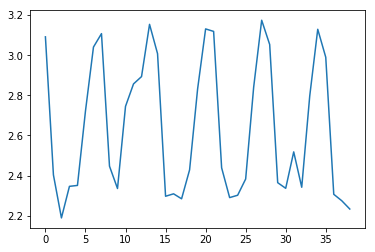

In [41]:
plt.plot(testpreds[129])

In [42]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))

In [43]:
preddf=preddf.unstack().reset_index()

In [44]:
preddf.columns=['date','store','transformed_visitors']

In [45]:
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)

In [46]:
preddf['visitors']=np.expm1(preddf['transformed_visitors'])

In [47]:
preddf=preddf.set_index(preddf['id'])

In [48]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.188151   
air_0164b9927d20bcc3_2017-04-23              1.237308   
air_0241aa3964b7f861_2017-04-23              2.368189   
air_0328696196e46f18_2017-04-23              1.999322   
air_034a3d5b40d5b1b1_2017-04-23              3.476607   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   7.918710  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.446323  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.678038  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.384051  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.349779

In [49]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [50]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [51]:
submission.to_csv("../submission/2011_log_run_-7.csv.gz",compression='gzip')